# Derviving and implmenting resnet2resnet transformations

TODO: basically copy the abstract of the paper here

TODO: add some diagrams and visual and wordy understanding of what's going on

TODO: link to paper when published

TODO: add references to 231n pytorch tutorials (Justin Johnson's github) + the source code for convs, https://pytorch.org/docs/master/_modules/torch/nn/modules/conv.html as it's very instructive of how we will manipulate them

## Preamble
### Jupyter Notebook Config

Here's just some code to make matplotlib libraries etc play nice with jupyter notebooks. (So we just run the below code and don't worry about how it works).

This will setup plotting how we want it, make matplotlib and seaborn figures run inline and make imported library code auto-reload when changed.

The following code snippet was used in the assignments of [Stanford's cs231n](http://cs231n.stanford.edu/), and has been very useful!

In [1]:
# Some imports
import random
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
import time

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Seaborn config
sns.set(color_codes=True)

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Imports :)

In [14]:
# import the pytorch and numpy libraries we need now
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import numpy as np

# General python librarys that are useful
from itertools import chain

# load mnist dataset (with some logic to add the current directory to pythons path variable)
# We'll be using it a lot!
import os
import sys
dataset_module_path = os.path.abspath(os.path.join('.'))
if dataset_module_path not in sys.path:
    sys.path.append(dataset_module_path)
from dataset import MnistDataset
from dataset import DatasetCudaWrapper

Instructions for updating:
Use the retry module or similar alternatives.


### Helper functions

A place to put random helper functions that aren't really related to any part of the "story"... and **really** shoudl be inbuilt PyTorch functions.

In [3]:
def _flatten(x):
    """
    Flattens a tensor, 'x', with shape (batch_size, ...)
    """
    batch_size = x.size(0)
    return x.view((batch_size, -1))

## Cuda
Change the following flag if you have a GPU and wish to use it.

In [4]:
use_gpu = False

## Building Zero And Identity Initializations
### Initializing the kernel

As a building block, we provide code that will take some convolutional kernal F, and then "widen" the filter with duplicated weights E. That is, given F of shape (C1, I, W, H) and a number of new filters C2 to add, we randomly initialize E with shape (C2, I, W, H) and return [F;E;E] of shape (C1+2\*C2, I, W, H). (N.B. we use ';' for concatenation).

We begin by implementing the standard Xavier and He initializations (1st cell) with some additinal options. In the 2nd cell we implement taking a filter [F] and extending the kernel to [F;E;E]. Note, that this also allows us to initialize filters of the form [E;E], by letting F be empty. We implement two functions that perform this concetenation in the 0th and 1st dimensions respectively (corresponding to the output channels and input channels for a convolutional kernal respectively).

In [5]:
def _conv_xavier_initialize(filter_shape, override_input_channels=None, override_output_channels=None):
    """
    Initialize a convolutional filter, with shape 'filter_shape', according to "He initialization".
    The weight for each hidden unit should be drawn from a normal distribution, with zero mean and stddev of 
    sqrt(2/(n_in + n_out)).
    
    This is the initialization of choice for layers with non ReLU activations.
    
    The filter shape should be [output_channels, input_channels, width, height]. So here, 
    n_in = width * height * input_channels and n_out = width * height * output_channels.
    
    When "widening" an filter, from C1 output filters, to C1 + 2*C2 filters, then we want to initialize the 
    additional 2*C2 layers, as if there are C1+2*C2 filters in the output, and therefore we provide the 
    option to override the number of output filters.
    
    :param filter_shape: THe shape of the filter that we want to produce an initialization for
    :param override_output_channels: Override for the number of input filters in the filter_shape (optional)
    :param override_output_channels: Override for the number of output filters in the filter_shape (optional)
    :return: A numpy array, of shape 'filter_shape', randomly initialized according to He initialization.
    """
    out_channels, in_channels, width, height = filter_shape
    if override_input_channels is not None:
        in_channels = override_input_channels
    if override_output_channels is not None:
        out_channels = override_output_channels
    filter_shape = (out_channels, in_channels, width, height)    
    
    scale = np.sqrt(2.0 / (width*height(in_channels + out_chanels)))
    return scale * np.random.randn(*filter_shape).astype(np.float32) 
    
    

def _conv_he_initialize(filter_shape, override_input_channels=None, override_output_channels=None):
    """
    Initialize a convolutional filter, with shape 'filter_shape', according to "Xavier initialization".
    Each weight for each hidden unit should be drawn from a normal distribution, with zero mean and stddev of 
    sqrt(2/n_in).
    
    This is the initialization of choice for layers with ReLU activations.
    
    The filter shape should be [output_channels, input_channels, width, height]. So here, 
    n_in = width * height * input_channels.
    
    As the initization only depends on the number of inputs (the number of input channels), unlike Xavier 
    initialization, we don't need to be able to override the number of output_channels.
    
    :param filter_shape: THe shape of the filter that we want to produce an initialization 
    :param override_output_channels: Override for the number of input filters in the filter_shape (optional)
    :param override_output_channels: unused
    :return: A numpy array, of shape 'filter_shape', randomly initialized according to He initialization.
    """
    out_channels, in_channels, width, height = filter_shape
    if override_input_channels is not None:
        in_channels = override_input_channels
    filter_shape = (out_channels, in_channels, width, height)    
                    
    scale = np.sqrt(2.0 / (in_channels*width*height))
    return scale * np.random.randn(*filter_shape).astype(np.float32)




In [68]:
def _extend_filter_with_repeated_out_channels(extending_filter_shape, existing_filter=None, 
                                              init_type='He', alpha=1.0):
    """
    We want to extend filter by adding output channels with appropriately initialized weights.
    
    Let F be the 'existing_filter', with shape [C1,I,W,H]. 'extending_filter_shape' if the shape 
    by which we want to extend F. 
    
    Let 'extending_filter_shape' be [2*C2,I,W,H]. If the shape value that should be 2*C2 is odd or 
    non-positive, then it's an error.
    
    The shape of the extended filter is [C1+2*C2, I, W, H].
    
    The method initializes E of shape [C2, I, W, H] with the specified 'init_type'. The function returns 
    the concatenation [F;E;alpha*E], where concatination is in the inconsistent dimension and alpha is a 
    multiplicative scalar.
    
    To make a fresh/new filter, with repeated weights, let 'existing_filter' be None, and it will 
    return just [E;alpha*E], as F is "empty". (Concatenation in the output channels dimension.)
    
    :param extending_filter_shape: The shape of the new portion of the filter to return. I.e. [2*C2,I,W,H]
    :param existing_filter: If not None, it must have shape [C1,I,W,H]. This is the existing filter.
    :param init_type: The type of initialization to use for new weights.
    :return: A filter of shape [C1+2*C2, I, W, H], which is the 'existing_filter' extended by 2*C2 output channels. 
            I.e. the filter [F;E;alpha*E]
    """
    # Unpack params input.
    twoC2, I, W, H = extending_filter_shape
    C2 = twoC2 // 2
    C1 = 0 if existing_filter is None else existing_filter.shape[0]
    
    # Error checking.
    if twoC2 % 2 != 0:
        raise Exception("The filter shape needs to be even to allow for repetition in it.")
    elif existing_filter is not None and (W != existing_filter.shape[2] 
        or H != existing_filter.shape[3] or I != existing_filter.shape[1]):
        raise Exception("Dimensions of 'extending_filter_shape' and 'existing_filter' are incompatible.")
    
    # Canvas for the new numpy array to return. Copy existing filter weights.
    canvas = np.zeros((C1+twoC2, I, W, H)).astype(np.float32)
    if existing_filter is not None:
        canvas[:C1,:,:,:] = existing_filter

    # Initialize the new weights, and copy that into the canvas (twice).
    new_channels_weights = None
    if init_type == 'He':
        new_channels_weights = _conv_he_initialize((C2,I,W,H))
    elif init_type == 'Xavier':
        new_channels_weights = _conv_xavier_initialize((C2,I,W,H), override_output_channels=C1+twoC2)
    else:
        raise Exception("Invalid initialization type specified. Please use 'He' or 'Xavier'.")
    
    canvas[C1:C1+C2,:,:,:] = new_channels_weights
    canvas[C1+C2:C1+twoC2,:,:,:] = alpha * new_channels_weights

    # Done :)
    return canvas



def _extend_filter_with_repeated_in_channels(extending_filter_shape, existing_filter=None, 
                                             init_type='He', alpha=1.0):
    """
    We want to extend filter by adding input channels with appropriately initialized weights.
    
    This time we are repeating/concatenating over the input channels rather than output channels. 
    They're nearly identical. 
    (There is/was code to extend both input and output channels at once, but it's overly complex to use here.)
    
    Let F be the 'existing_filter', with shape [C,I1,W,H]. 'extending_filter_shape' if the shape 
    by which we want to extend F. 
    
    Let 'extending_filter_shape' be [C,2*I2,W,H]. If the shape value that should be '2*I2' is odd or 
    non-positive, then it's an error.
    
    The shape of the extended filter is [C, I1+2*I2, W, H].
    
    The method initializes E of shape [C, I2, W, H] with the specified 'init_type'. The function returns 
    the concatenation [F;E;alpha*E], where concatination is in the inconsistent dimension and alpha is a 
    multiplicative scalar.
    
    To make a fresh/new filter, with repeated weights, let 'existing_filter' be None, and it will 
    return just [E;alpha*E], as F is "empty". (Concatenation in the input channel dimension.)
    
    :param extending_filter_shape: The shape of the new portion of the filter to return. I.e. [C,2*I2,W,H]
    :param existing_filter: If not None, it must have shape [C,I1,W,H]. This is the existing filter.
    :param init_type: The type of initialization to use for new weights.
    :return: A filter of shape [C, I1+2*I2, W, H], which is the 'existing_filter' extended by 2*I2 input channels. 
            I.e. the filter [F;E;alpha*E]
    """
    # Unpack params input.
    C, twoI2, W, H = extending_filter_shape
    I2 = twoI2 // 2
    I1 = 0 if existing_filter is None else existing_filter.shape[1]
    
    # Error checking.
    if twoI2 % 2 != 0:
        raise Exception("The filter shape needs to be even to allow for repetition in it.")
    elif existing_filter is not None and (W != existing_filter.shape[2] 
        or H != existing_filter.shape[3] or C != existing_filter.shape[0]):
        raise Exception("Dimensions of 'extending_filter_shape' and 'existing_filter' are incompatible.")
    
    # Canvas for the new numpy array to return. Copy existing filter weights.
    canvas = np.zeros((C, I1+twoI2, W, H)).astype(np.float32)
    if existing_filter is not None:
        canvas[:,:I1,:,:] = existing_filter

    # Initialize the new weights, and copy that into the canvas (twice).
    new_channels_weights = None
    if init_type == 'He':
        new_channels_weights = _conv_he_initialize((C,I2,W,H))
    elif init_type == 'Xavier':
        new_channels_weights = _conv_xavier_initialize((C,I2,W,H), overried_input_channels=I1+twoI2)
    else:
        raise Exception("Invalid initialization type specified. Please use 'He' or 'Xavier'.")
    
    canvas[:,I1:I1+I2,:,:] = new_channels_weights
    canvas[:,I1+I2:I1+twoI2,:,:] = alpha * new_channels_weights

    # Done :)
    return canvas

## Putting together a zero initialization

We define a nn.Module called a "R2R_block", which is what we will use to denote any block that we can specify that it should be "zero initialized". Zero initialized means that the output will be identically zero for any given input.

Now we can make a nn.Module involving multiple convolutional layers (in this case we will work with 2 for now), and initialize it so that the output is zero, for every input. This provides a "convolutional layer" (it's obviously more than just a single convolution) to be used as a building block in larger networks. 

One limitation is that the output of the block will be a fixed size, as the widenings are applied internally.

We don't provide any filter extending (althrough we implemented the numpy code necessary for it above), and we only initialize convolutions in a specific way. The work for "widening" the network through training will be implemented later.

In [7]:
def _noise(shape, scale):
    return scale * np.random.randn(*shape).astype(np.float32)

In [8]:
class R2R_block_v1(nn.Module):
    """
    Defines a R2R block, version 1, this will be our first iteration and so we will make some (arbitrary) design 
    choices for now, just to make prototyping easier. The R2R block refers to a small block that can be 
    initialized such that the output is identically zero for any input.
    
    R2R block V1 consists of the following network layers/operations:
        (optional) max pool
        k1*k1 conv2d
        batchnorm
        activation function
        k2*k2 conv2d (with k2=1)
        
    Simplifying assumptions that we make for now:
        0. k1 = 3. It doesn't need to be.
        1. k2 = 1, it doesn't need to be.
        2. We don't actually want k1*k1 convolutions always, we need to have 1*7 and so on to implement inception 
            networks.
        3. We need to be able to extend the sizes of the filters at runtime. We compltely omit this here. This 
            will require some function to iterate over the layers and apply the function:
            layr, nxtLayr = r2r(layr, nxtLayr)
        4. More activations that just ReLU.
        5. Options for how to initialize new weights.
        6. Not just convolutional layers (linear also).
        7. Padding and stride are such that input's spatial dimensions are maintained.
        8. Obviously not just a two layer block, but, have a list of convolutions to apply/use
        
    Shape analysis (use [.;.]_i to denote concatenation in ith dimension):
        0. Given some input with shape [D,A,B], and ignoring any max pooling (assume it happens before the analysis).
        1. The first convolutional filter is initialized using [F1;F1]_0, where F1 is randomly initialized and of 
            shape [C,D,k1,k1]. So the filter [F1;F1] has shape [2*C,D,k1,k1].
        2. After applying the convolution (with kernel [F1;F1]) to the input (With shape [D,A,B]), the volume 
            now has shape [2*C,A,B]
        3. The second convolutional filter is initialized using [F2; -F2]_1, where F2 is randomly initialized with 
            shape [O,C,k2,k2]. So the filter [F2;-F2] has shape [O,2*C,k2,k2]
        4. The output volume will have shape [O,A,B], after the filter [F2;-F2] has been applied.
    """
    def __init__(self, input_channels, intermediate_channels, output_channels, 
                 add_max_pool=False, add_batch_norm=True, zero_initialize=True, noise_ratio=1e-3):
        """
        Initializes each of the layers in the R2R module, and initializes the variables appropriately. That is 
        if zero_initialize == True, then we initialize the network to have a constant zero output.
        
        In the 'shape analysis' above, input_channels, intermediate_channels and output_channels correspond to 
        the variables D, 2*C, O respectively.
        
        :param input_channels: The number of input channels provided to the conv2d layer
        :param intermediate_channels: The number of output channels from the first conv2d layer, and the number 
                of input channels to the 1*1 convolution
        :param output_channels: The number of channels outputted by the whole module
        :param add_max_pool: if we should add a max pool layer at the beginning
        :param add_batch_norm: if we should add a batch norm layer in the middle, before the activation function
        :param zero_initialize: should we initialize the module such that the output is always zero?
        :param noise_ratio: the amount of noise to add, as ratio (of the max init weight in the conv2d kernel) 
                (break symmetry)
        """
        # Superclass initializer
        super(R2R_block_v1, self).__init__()
        
        self.has_max_pool = add_max_pool
        self.has_batch_norm = add_batch_norm
    
        # Make the layers
        self.opt_max_pool = lambda x: x
        if add_max_pool:
            self.opt_max_pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(input_channels, intermediate_channels, kernel_size=3, padding=1)
        self.opt_batch_norm = lambda x: x 
        if add_batch_norm:
            self.opt_batch_norm = nn.BatchNorm2d(num_features=intermediate_channels)
        self.activation_function = F.relu
        self.conv2 = nn.Conv2d(intermediate_channels, output_channels, kernel_size=1)

        # If providing a zero initialization, do all of our repeated weight trickery!
        if zero_initialize:
            # Initialize the conv weights as appropriate, using the helpers and adding a small amount of noise
            conv1_filter_shape = (intermediate_channels, input_channels, 3, 3)
            conv1_filter_init = _extend_filter_with_repeated_out_channels(conv1_filter_shape, init_type='He')
            
            self.conv1.weight.data = Parameter(t.Tensor(conv1_filter_init))
            self.conv1.bias.data *= 0.0
            
            conv2_filter_shape = (output_channels, intermediate_channels, 1, 1)
            conv2_filter_init = _extend_filter_with_repeated_in_channels(conv2_filter_shape, init_type='He', 
                                                                       alpha=-1.0)
            
            self.conv2.weight.data = Parameter(t.Tensor(conv2_filter_init))
            self.conv2.bias.data *= 0.0
            
            # Initialize the batch norm variables so that the scale is one and the mean is zero
            if add_batch_norm:
                self.opt_batch_norm.weight.data = Parameter(t.Tensor(t.ones(intermediate_channels)))
                self.opt_batch_norm.bias.data = Parameter(t.Tensor(t.zeros(intermediate_channels)))
                
            
            
    def forward(self, x):
        """
        Forward pass of the module.
        If max pool and batch norm were not specified to be used, then self.opt_max_pool and/or self.opt_batch_norm 
        is a lambda identity function.
        
        :param x: The input tensor
        :return: The output from the module
        """
        x = self.opt_max_pool(x)
        x = self.conv1(x)
        x = self.opt_batch_norm(x)
        x = self.activation_function(x)
        x = self.conv2(x)
        return x

## Sanity checking what we've done so far

Now, lets run a few tests, as follows, to sanity check that everything that we've done so far works how we intended it to. These tests can be run in verbose mode (where the output of the last (random) input is also printed out, but, the output tends to be pretty large in that case, which is why allow for turning it off).

1. Set the noise to zero, and check that the output is zero for *any* input. Initially do this without batch norm.
2. Do the same, but with batch norm added.
2. Set the noise to a small variable, and check that the output is approximately zero (and non-symmetric).
4. Repeat test 3, with batch norm 
3. To gauge the effect that noise has, run the previous test, with a number of noise ratios.
5. Repreate test 5, with batch norm

In [9]:
# Verbose 
verbose = False

# Helper to make printing a little prettier :)
def indprint(string, tabs=0):
    print("\t" * tabs + string.replace('\n', '\n'+'\t'*tabs))
    
    
    
##########
# Test 1 #
##########
indprint("Test 1: Zero initialized module, no batch norm, zero noise, check with 10 different inputs that the output is zero.")
r2r = R2R_block_v1(8,8,4, add_max_pool=False, add_batch_norm=False, zero_initialize=True, noise_ratio=0.0)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,8,4,4)))
    output = r2r(rand_inputs)
    indprint("On iter %d, average output value magnitude is %f" % (i, t.sum(t.abs(output))), 1)
    
if verbose:
    indprint("%s" % output, 1)
    print('\n' * 4)
    
    
    
##########
# Test 2 #
##########
indprint("Test 2: same as test 1, with batch norm added, and max pooling added")
r2r = R2R_block_v1(4,2,2, add_max_pool=True, add_batch_norm=True, zero_initialize=True, noise_ratio=0.0)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,6,6)))
    output = r2r(rand_inputs)
    indprint("On iter %d, average output value magnitude is %f" % (i, t.sum(t.abs(output))), 1)
    
if verbose:
    indprint("%s" % output, 1)
    print('\n' * 4)
    
    
    
##########
# Test 3 #
##########
indprint("Test 3: same as test 1, with a small amount of noise added")
r2r = R2R_block_v1(4,4,2, add_max_pool=False, add_batch_norm=False, zero_initialize=True)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,5,5)))
    output = r2r(rand_inputs)
    vals = (i, t.sum(t.abs(output)), t.sum(t.abs(output))/t.sum(t.abs(rand_inputs)))
    indprint("On iter %d, average output value magnitude is %f, ratio of magnitudes output/input is %f" 
             % vals, 1)
    
if verbose:
    indprint("%s" % output, 1)
    print('\n' * 4)
    
    
    
##########
# Test 4 #
##########
indprint("Test 4: same as test 3, with batch norm")
r2r = R2R_block_v1(4,4,2, add_max_pool=False, add_batch_norm=True, zero_initialize=True)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,5,5)))
    output = r2r(rand_inputs)
    vals = (i, t.sum(t.abs(output)), t.sum(t.abs(output))/t.sum(t.abs(rand_inputs)))
    indprint("On iter %d, average output value magnitude is %f, ratio of magnitudes output/input is %f" 
             % vals, 1)
    
if verbose:
    indprint("%s" % output, 1)
    print('\n' * 4)
    


##########
# Test 5 #
##########
indprint("Test 5: compare outputs, with the same input, given different noise ratios (no batch norm or max pool)")

# fixed input
rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,5,5)))

# run with different lwevels of noise in the kernel
for noise in [10.0**i for i in range(-10, 2)]:
    r2r = R2R_block_v1(4,4,2, add_max_pool=False, add_batch_norm=False, zero_initialize=True, noise_ratio=noise)
    output = r2r(rand_inputs)
    
    # analysis
    output_magnitudes = t.sum(t.abs(output))
    output_magnitudes_ratio = output_magnitudes/t.sum(t.abs(rand_inputs))
    vals = (noise, output_magnitudes, output_magnitudes_ratio) 
    indprint(("Noise ratio of %E, \n\tgives average output magnitude of %E," + 
             "\n\tratio of output/input magnitudes is %E") % vals, 1)
    
if verbose:
    print('\n' * 4)
    


##########
# Test 6 #
##########
indprint("Test 6: same as test 5, with batch norm added")

# fixed input
rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,5,5)))

# run with different lwevels of noise in the kernel
for noise in [10.0**i for i in range(-10, 2)]:
    r2r = R2R_block_v1(4,4,2, add_max_pool=False, add_batch_norm=False, zero_initialize=True, noise_ratio=noise)
    output = r2r(rand_inputs)
    
    # analysis
    output_magnitudes = t.sum(t.abs(output))
    output_magnitudes_ratio = output_magnitudes/t.sum(t.abs(rand_inputs))
    vals = (noise, output_magnitudes, output_magnitudes_ratio) 
    indprint(("Noise ratio of %E, \n\tgives average output magnitude of %E," + 
             "\n\tratio of output/input magnitudes is %E") % vals, 1)

Test 1: Zero initialized module, no batch norm, zero noise, check with 10 different inputs that the output is zero.
	On iter 0, average output value magnitude is 0.000003
	On iter 1, average output value magnitude is 0.000003
	On iter 2, average output value magnitude is 0.000002
	On iter 3, average output value magnitude is 0.000006
	On iter 4, average output value magnitude is 0.000003
	On iter 5, average output value magnitude is 0.000003
	On iter 6, average output value magnitude is 0.000004
	On iter 7, average output value magnitude is 0.000003
	On iter 8, average output value magnitude is 0.000004
	On iter 9, average output value magnitude is 0.000004
Test 2: same as test 1, with batch norm added, and max pooling added
	On iter 0, average output value magnitude is 0.000000
	On iter 1, average output value magnitude is 0.000000
	On iter 2, average output value magnitude is 0.000000
	On iter 3, average output value magnitude is 0.000000
	On iter 4, average output value magnitude is

### Arriving at a identity initialization through residual connections

Now that we can initialize a convolutional stack to have a constant zero output (initialize the last two layers as we did above for any stack), we can wrap it in a residual block, thus providing an identity initialization of that residual block.

When we add a residual connection, our neural network (block) learns a function $F(x)$, and the output of the residual block is $h(x)=x+F(x)$. As we can initialize $F$ such that for all $x$ we have $F(x)=0$, then we have that $h(x)=x$ for all x.

In [10]:
class R2R_residual_block_v1(nn.Module):
    """
    A small residual block to be used for mnist/cifar10 tests. This is reletively simple, and is just the same 
    as building a small network in PyTorch, using "R2R_Block_v1" as one of the layers.
    
    It consists one set of convolutional layers (not multiple sizes of convolutions like Inception ResNet)
    It has the following architecture:
        Conv2D
        BatchNorm
        ReLU
        Conv2D
        BatchNorm
        ReLU
        R2R_block_v1         <- can chose to initialize so that the output is zero (and this block is an identity transform)
            Conv2D          
            BatchNorm
            ReLU
            Conv2D
            (implicit linear activation)
        
        + residual connection
        
    To deal with dimensionality issues, we use zero padding for the residual connection. We also use a 
    bit of masking in the zero padding, so that the residual connection is always the same shape.
    
    It would be good to fix this limitation of not being able to increase the residual connection size.
    """
    def __init__(self, input_channels, output_channels, identity_initialize=True, noise_ratio=0.0):
        """
        Initialize the filters, optionally making this identity initialized.
        All convolutional filters have the same number of output channels
        """
        # Superclass initializer
        super(R2R_residual_block_v1, self).__init__()
    
        self.residual_channels = input_channels
        self.noise_ratio = noise_ratio
        
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=output_channels)
        self.relu = F.relu
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=output_channels)
        
        self.r2r = R2R_block_v1(output_channels, output_channels, output_channels, 
                                zero_initialize=identity_initialize, noise_ratio=noise_ratio)
        
        
        
    def forward(self, x):
        """
        Forward pass through this residual block
        
        :param x: the input
        :return: THe output of applying this residual block to the input
        """
        # Forward pass through residual part of the network
        res = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.r2r(x)
        
        # add residual connection (implicit zero padding)
        out = x
        out[:, :self.residual_channels] += res[:, :self.residual_channels]
        
        return out        

### More sanity checks

So now we just do one more sanity checks, which involves checking if we did indeed define an itentity operator above. 

In [11]:
verbose = False

##########
# Test 7 #
##########
indprint("Test 7: Check that the identity resnet module is indeed an identity function.")
res_block = R2R_residual_block_v1(2,4)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,2,5,5)))
    output = res_block(rand_inputs)
    indprint("On iter %d, average difference between input and output is %f" 
             % (i, t.sum(t.abs(output[:,:2] - rand_inputs))), 1)
    
if verbose:
    indprint("Input:", 1)
    indprint("%s" % rand_inputs, 1)
    indprint("Output:", 1)
    indprint("%s" % output, 1)
    indprint("Diff on common dim:s", 1)
    indprint("%s" % (output[:,:2]-rand_inputs), 1)

Test 7: Check that the identity resnet module is indeed an identity function.
	On iter 0, average difference between input and output is 0.000000
	On iter 1, average difference between input and output is 0.000000
	On iter 2, average difference between input and output is 0.000000
	On iter 3, average difference between input and output is 0.000000
	On iter 4, average difference between input and output is 0.000000
	On iter 5, average difference between input and output is 0.000000
	On iter 6, average difference between input and output is 0.000001
	On iter 7, average difference between input and output is 0.000000
	On iter 8, average difference between input and output is 0.000001
	On iter 9, average difference between input and output is 0.000000


### Training a small netowork, with 3 resnet modules, 3 max pools, and a fc output

To 'cap off' the "Building Zero And Identity Initializations" section, we're going to build a small residual block, that we can identity initialize. Then we're going to stack a few of these residual blocks together, and train a classifier on CIFAR-10 to sanity check that we can indeed still learn when identity initializations are used.

The first cell below defines a training loop used to evaluate our models; the second cell defines our small ResNet which we can optionally initialized the convolutional part of the network; the third cell runs the training loops a few times, evaluating the networks on Mnist; and the fourth cell will print out some graphs displaying the results, and should indicate if we "can still learn when using an identity initialization". 

In [12]:
# compute the accuracy of a prediction
def accuracy(prediction, target):
    _, pred_classes = t.max(prediction, 1)
    _, actual_classes = t.max(target, 1)
    return t.mean((pred_classes == actual_classes).type(t.float))

# Evaluate a model
def evaluate(model, dataset):
    # Setup bookeeping and optimizer
    train_iters = 800
    epoch_len = 10
    train_accuracies = []
    val_accuracies = []
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
    
    # train for 500 iterations, evaluating every epoch
    for i in range(train_iters+1):
        # compute loss
        xs, ys = dataset.next_batch(64)
        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys)
        
        # make a step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # log at the beginning/end of every epoch
        if i % epoch_len == 0:
            train_acc = accuracy(ys_pred, ys)
            
            xs, ys = dataset.next_val_batch(128)
            ys_pred = model(xs)            
            val_acc = accuracy(ys_pred, ys)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            
            print("(Iter %d). Current train: %0.6f, Current val: %0.6f." % (i, train_acc, val_acc))
            
    return train_accuracies, val_accuracies

In [13]:
# small network for MNist classes. This just simply strings together 3 residual blocks, with max pools between them
class Mnist_Resnet_v1(nn.Module):
    def __init__(self, identity_initialize=True):
        # Superclass initializer
        super(Mnist_Resnet_v1, self).__init__()
        
        # Make the three conv layers, with three max pools
        self.resblock1 = R2R_residual_block_v1(input_channels=1, 
                                               output_channels=16, 
                                               identity_initialize=identity_initialize) # [-1, 16, 32, 32]
        self.pool1 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 16, 16, 16]
        self.resblock2 = R2R_residual_block_v1(input_channels=16, 
                                               output_channels=32, 
                                               identity_initialize=identity_initialize) # [-1, 32, 16, 16]
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 32, 8, 8]
        self.resblock3 = R2R_residual_block_v1(input_channels=32, 
                                               output_channels=64, 
                                               identity_initialize=identity_initialize) # [-1, 64, 8, 8]
        self.pool3 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 64, 4, 4]
        
        # fully connected out
        self.linear1 = nn.Linear(4*4*64, 256)
        self.linear2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # convs
        x = self.resblock1(x)
        x = self.pool1(x)
        x = self.resblock2(x)
        x = self.pool2(x)
        x = self.resblock3(x)
        x = self.pool3(x)
        
        # fc
        x = x.view((-1, 4*4*64))
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        
        return x

In [37]:
# Make a Mnist dataset, appropriately returning cuda/non-cuda variables 
dataset = DatasetCudaWrapper(MnistDataset(64)) if use_gpu else MnistDataset(64)

# run our initialization 5 times
our_init_results = []
our_init_results_val = []
times = []
for i in range(5):
    model = Mnist_Resnet_v1(True)
    if use_gpu: 
        model = model.cuda()
        
    start_time = time.time()
    train_acc, val_acc = evaluate(model, dataset)
    elapsed_time = time.time() - start_time
    del model
    
    our_init_results.append(train_acc)
    our_init_results_val.append(val_acc)
    times.append(elapsed_time)

our_init_mean_time = np.mean(times)
our_init_stddev_time = np.std(times)
    
# run he initialization 5 times
he_init_results = []
he_init_results_val = []
for i in range(5):
    model = Mnist_Resnet_v1(False)
    if use_gpu:
        model = model.cuda()
        
    train_acc, val_acc = evaluate(model, dataset)
    del model
    he_init_results.append(train_acc)
    he_init_results_val.append(val_acc)


NameError: name 'python' is not defined

/media/michael/DATA1/anaconda/envs/cs231n/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/media/michael/DATA1/anaconda/envs/cs231n/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


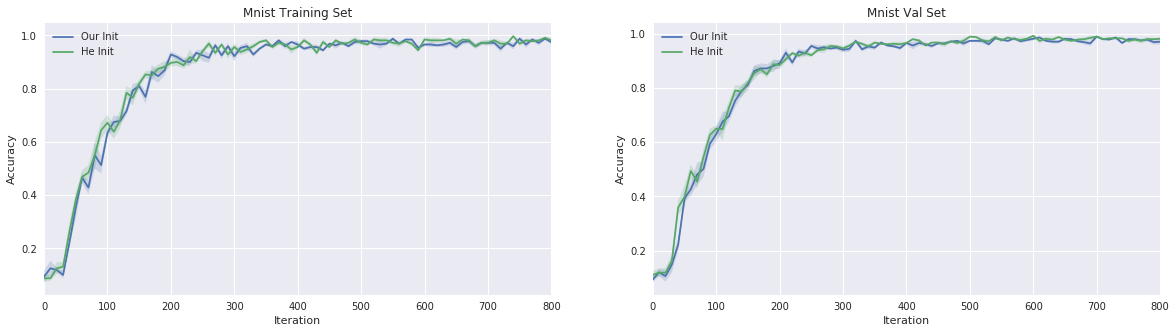

In [38]:
# Plot the results of the above tests with confidence intervals
plt.figure(figsize=(20,5))
plt.tight_layout()

xaxis = np.array(range(81)) * 10

plt.subplot(121)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
sns.tsplot(data=our_init_results, time=xaxis, condition="Our Init")
sns.tsplot(data=he_init_results, time=xaxis, color="g", condition="He Init")
plt.legend()

plt.subplot(122)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=our_init_results_val, time=xaxis, condition="Our Init")
sns.tsplot(data=he_init_results_val, time=xaxis, color="g", condition="He Init")

## Implementing R2WiderR and R2DeeperR (, and a entire network widening function)

Now that we've shown that identity intiializations can actually do well, we have some sort of basis to believe that our deepening transforms will actually work. 

Now we move onto writing code that will widen the volume of a single hidden layer (by editing the input and output convolutions to that layer) such that we preserve the networks transform. 

So now we will now implement our widening transform and deepen transforms in this section.


### Implementing Filter Widening Logic, including R2WiderR

We begin by defining functions to perform widening (at a tensor level). As this will be needed for widening the internal tensors of Batch Norm.

**Note that `widen_hidden_volume` is exactly the implementation of R2WiderR**.

In [15]:
def _zero_pad_1d(old_val, new_params):
    """
    Zero pads an old (1d) tensor to match the new number of outputs
    
    :param old_val the old numpy tensor to zero pad
    :param new_params: the number of new params needed
    :return: a new, padded tensor
    """
    old_len = old_val.shape[0]
    canvas = np.zeros((old_len+new_params,), dtype=np.float32)
    canvas[:old_len] = old_val
    return canvas



def _one_pad_1d(old_val, new_params):
    """
    One pads an old (1d) tensor to match the new number of outputs
    
    :param old_val the old numpy tensor to one pad
    :param new_params: the number of new params needed
    :return: a new, padded tensor
    """
    old_len = old_val.shape[0]
    canvas = np.ones((old_len+new_params,), dtype=np.float32)
    canvas[:old_len] = old_val
    return canvas



def _widen_hidden_volume(prev_kernel, prev_bias, next_kernel, extra_channels=0, init_type='He', 
                         function_preserving=True):
    """
    This is an implementation of our "R2WiderR". 
    
    This function will widen a single hidden volume as part of a CNN. To widen the volume, we need to 
    add additional output filters to the kernel before this volume. Then, we also need to add additonal 
    input filters to the kernel after this volume. 
    
    Having written '_extend_filter_with_repeated_out_channels' and '_extend_filter_with_repeated_in_channels'
    very generally, we can piggyback off that prior work. If we want the widening to be function preserving 
    then set alpha=-1.0 in the repeated in channels of the next kernel, to implement the R2WiderR transform,
    as described in the paper.
    
    :param prev_kernel: The numpy Tensor for the kernel of the convolution that computes the hidden 
            volume that we are extending. (I.e. the kernel preceeding the volume being extended.) 
    :param prev_bias: The numpy Tensor for the bias of the convolution preceeding the volume being extended.
    :param next_kernel: The numpy Tensor for the kernel of the convolution used after this volume.
    :param extra_channels: The number of extra channels to add to the hidden volume.
    :param init_type: The tpye
    :return: new_prev_kernel, new_prev_bias, new_next_kernel. Which are all numpy Tensors to be appropriately 
            set allocated as PyTorch Parameters in the networks.
    """
    # For us to be able to perform a function preserving transforms, extra channels must be even and non-negative
    if extra_channels <= 0 or (function_preserving and extra_channels % 2 != 0):
        raise Exception("Invalid number of extra channels in widen.")
        
    # Compute new kernel for the 'prev_kernel'
    _, in_channels, width, height = prev_kernel.shape
    kernel_extra_shape = (extra_channels, in_channels, width, height)
    prev_kernel = _extend_filter_with_repeated_out_channels(kernel_extra_shape, prev_kernel, init_type)
    
    # Zero pad the 'prev_bias'
    prev_bias = _zero_pad_1d(prev_bias, extra_channels)
    
    # Compute the new kernel for 'next_kernel'
    alpha = -1.0 if function_preserving else 1.0
    out_channels, _, width, height = next_kernel.shape 
    kernel_extra_shape = (out_channels, extra_channels, width, height)
    next_kernel = _extend_filter_with_repeated_in_channels(kernel_extra_shape, next_kernel, init_type, alpha)
    
    # Doneee :)
    return prev_kernel, prev_bias, next_kernel
    
    
    
# def _widen_kernel_with_repeated_in_repeated_output(old_kernel, old_bias, extra_in_channels=0, 
#                                                    extra_out_channels=0, repeated_in=True, 
#                                                    repeated_out=True, init_type='He'):
#     """
#     A revised version of the logic to widen a kernel. We pass in the old kernel, the number of channels 
#     extended in a convolution before it (zero if the convolution before it hasn't been widened), and 
#     the number of new channels for the output.
    
#     If the old shape was [Ou,I,W,H] and the new shape is [Ou2,I2,W,H], so Ou2 is the new number of output 
#     channels and Ou is the old number of output channels, when we initialize as follows:
    
#     Letting hOu = (Ou2-Ou)/2
#     and hI = (I2-I)/2
#     and r1, r2, r3 are appropriately randomly initialized 
    
#         In \ Out |      0:Ou      |    Ou:Ou+hOu    |   Ou+hOu:Ou2    
#         -------------------------------------------------------------
#              0:I |  old[0:Ou,0:I] |  r1[0:hOu,0:I]  |  r1[0:hOu,0:I]  
#         -------------------------------------------------------------       
#           I:I+hI |  r2[0:Ou,0:hI] |  r3[0:hOu,0:hI] |  r3[0:hOu,0:hI] 
#         -------------------------------------------------------------
#          I+hI:I2 | -r2[0:Ou,0:hI] | -r3[0:hOu,0:hI] | -r3[0:hOu,0:hI]   
         
         
#     Note, if we change either repeated_input or repeated_output, then, we no longer have a function preserving
#     transfom. And we ignore the above grid.
    
#     :param old_kernel: the old kernel of the convolution layer (of shape (A,B,W,H))
#     :param old_bias: the old bias of the convolution layer (of shape (A,))
#     :param extra_in_channels: the number of new channels being input to this layer (A2-A)
#     :param extra_out_channels: the number of new channels being output from this layer (B2-B)
#     :param repeated_in: if we want to handle repeated input (of NEW input channels)
#     :param repeated_out: if we want to make the NEW output channels repeated 
#     :param init_type: The type of initialization to use for the kernel
#     :return: A new, larger filter and bias. (Initialized appropriately for a function preserving transform)
#     """
#     if extra_in_channels % 2 != 0 or extra_out_channels % 2 != 0:
#             # TODO: log an appropraite error message
#             raise Exception()
    
#     # compute values related to kernel size
#     Ou, I, W, H = old_kernel.size()
#     hOu = extra_out_channels // 2
#     hI = extra_in_channels // 2
#     total_new_in_channels = I + extra_in_channels
#     total_new_out_channels = Ou + extra_out_channels
    
#     # init function
#     init = None
#     if init_type == "He":
#         init = lambda shape: t.tensor(_conv_he_initialize(shape, total_new_in_channels, total_new_out_channels))
#     elif init_type == "Xavier":
#         init = lambda shape: t.tensor(_conv_xavier_initialize(shape, total_new_in_channels, total_new_out_channels))
    
#     # compute r1, r2, r3 as above.
#     if hOu > 0:
#         r1 = init((hOu,  I, W, H)) 
#     if hI > 0:
#         r2 = init(( Ou, hI, W, H))
#     if hOu > 0 and hI > 0:
#         r3 = init((hOu, hI, W, H))
    
#     # make a canvas and fill it appropriately
#     # ignore repetitions appropriately if either negate_repeated_new_input, repeat_new_output is false
#     canvas = t.zeros((total_new_out_channels, total_new_in_channels, W, H))
    
#     # top left four squares
#     canvas[:Ou, :I] = old_kernel
#     if hOu > 0:
#         canvas[Ou:Ou+hOu, :I] = r1
#     if hI > 0:
#         canvas[:Ou, I:I+hI] = r2
#     if hOu > 0 and hI > 0:
#         canvas[Ou:Ou+hOu, I:I+hI] = r3
    
#     # bottom left two squares
#     if hI > 0:
#          canvas[:Ou, I+hI:I+2*hI] = -r2 if repeated_in else init((Ou, hI, W, H))
#     if hOu > 0 and hI > 0:
#         canvas[Ou:Ou+hOu, I+hI:I+2*hI] = -r3 if repeated_in else init((hOu, hI, W, H))
        
#     # right three squares    
#     if hOu > 0:
#         canvas[Ou+hOu:Ou+2*hOu] = canvas[Ou:Ou+hOu] if repeated_out else init((hOu, I+2*hI, W, H))
        
#     # Bias just needs to be zero padded appropriately
#     return canvas, _zero_pad_1d(old_bias, extra_out_channels)



# def _widen_kernel_with_repreated_in(old_kernel, old_bias, extra_input_channels, init_type='He'):
#     """
#     Code for repeated_in and repreated_out breaks if one of the values is zero. 
#     So for just repeated in, can't just pass in a zero, and have to 
#     """



# def _widen_kernel_with_repeated_out(old_kernel, old_bias, extra_output_channels, init_type='He'):
#     """
#     This just passes off to the widen function we've already written, and combines is with extending the bias
#     This extends the filter, assuming a FIXED input size, to increase the number of output filters
    
#     :param: 
    
#     :param old_kernel: the old kernel of the convolution layer
#     :param old_bias: the old bias of the convolution layer 
#     :param extra_output_channels: the number of new channels being output from this layer
#     :param init_type: The type of init to use for the initialization
#     :return: The new kernel, same as the old, with more output filters (repeated as needed for a function preserving transform)
#     """
#     if extra_output_channels % 2 != 0:
#             # TODO: log an appropraite error message
#             raise Exception()
            
#     # compute values related to kernel size
#     Ou, I, W, H = old_kernel.size()
#     total_new_in_channels = I + extra_in_channels
#     total_new_out_channels = Ou + extra_out_channels
#     extending_filder_shape = (total_new_out_channels, total_new_in_channels, W, H)
    
#     # make new kernel and bias
#     new_kernel = _extend_filter_with_repeated_output(extending_filter_shape, 
#                                                    existing_filter=old_kernel.numpy(), 
#                                                    init_type=init_type)
#     new_kernel = t.tensor(new_kernel)
#     new_bias = _pad_bias(old_bias, total_new_out_channels)
    
#     return new_kernel, new_bias

### Dynamically re-assigning weights to convs
This is a little more complex than one might think, because we need to make everything compatible with PyTorch's internals.

Here we implement helper functions to be used in assigning the kernels and/or biases of a Conv2d module.

This ends up fiddling around with PyTorch internals quite a bit, so the first cell below is intended to print out some information that makes it a little more clear what the variables we are playing around with are. Specifically, we print out `conv._paramters`, which is the list of (trainable) parameters in the conv2d. The correct way to allocate a new parameter in this list is to use `conv.register_parameter(<param_name>, param)`. Note that this it automatically called when you instantiate a new Parameter in the constructor of an `nn.Module`, which will not be the case when we dynamically widen, so we need to manually register parameters.

In [16]:
conv = nn.Conv2d(1, 3, kernel_size=2, padding=1)
print("Parameters of conv2d:")
print(conv._parameters)
bn = nn.BatchNorm2d(num_features=2)
print("Parameters of BatchNorm:")
print(bn._parameters)
print("Buffers of BatchNorm:")
print(bn._buffers)

Parameters of conv2d:
OrderedDict([('weight', Parameter containing:
tensor([[[[ 0.0918,  0.4693],
          [ 0.0885,  0.2244]]],


        [[[-0.3661, -0.4264],
          [ 0.1122,  0.0654]]],


        [[[-0.0181,  0.2386],
          [ 0.1653, -0.4041]]]])), ('bias', Parameter containing:
tensor([-0.0205,  0.4496, -0.0008]))])
Parameters of BatchNorm:
OrderedDict([('weight', Parameter containing:
tensor([ 0.4797,  0.9637])), ('bias', Parameter containing:
tensor([ 0.,  0.]))])
Buffers of BatchNorm:
OrderedDict([('running_mean', tensor([ 0.,  0.])), ('running_var', tensor([ 1.,  1.]))])


In [17]:
def _assign_kernel_and_bias_to_conv_(conv, kernel, bias=None):
    """
    Assigns 'kernel' and 'bias' to be the kernel and bias of the nn.Conv2d 'conv'.
    If 'bias' is None, then, we keep the old bias.
    
    :param conv: An instance of nn.Conv2d to assign the kernel to
    :param kernel: A numpy tensor to assign to nn.Conv2d.weight (the kernel parameter)
    :return: A reference to the updated conv
    """
    # If bias is none, we can safely re-assign the old bias
    if bias is None:
        bias = conv.bias.data.cpu().numpy()
    
    # Sanity check new shaping values
    out_channels, in_channels, kernel_width, kernel_height = kernel.shape
    bias_size = bias.shape[0]
    if bias_size != out_channels:
        raise Exception("Trying to assign inconsistend kernel and biases in convolution.")
    
    # Update weight, bias and shape values in 'conv'
    conv.weight = Parameter(t.tensor(kernel))
    conv.bias = Parameter(t.tensor(bias))
    
    conv.out_channels = out_channels
    conv.in_channels = in_channels
    conv.kernel_size = (kernel_width, kernel_height)
    
    # Re-register the new weight and bias in the conv
    conv.register_parameter('weight', conv.weight)
    conv.register_parameter('bias', conv.bias)
    
    # Move to GPU if need be
    if use_gpu:
        conv = conv.cuda()
        
    return conv



def _assign_to_batch_norm_(batch_norm, scale, bias, run_mean, run_var):
    """
    Update 'batch_norm' with a new scale, bias and running mean and running variance
    """
    # Assign new params
    batch_norm.weight = Parameter(t.tensor(scale))
    batch_norm.bias = Parameter(t.tensor(bias))
    
    # Re register new params, and set running mean and var
    batch_norm.register_parameter('weight', batch_norm.weight)
    batch_norm.register_parameter('bias', batch_norm.bias)
    batch_norm.running_mean = t.tensor(run_mean)
    batch_norm.running_var = t.tensor(run_var)
    
    # Move to gpu if need be
    if use_gpu:
        batch_norm = batch_norm.cuda()
    
    return batch_norm

### R2R_residual_block_v2 and Mnist_Resnet_v2

Now we want to add additional functionality to our residual block and residual network. Specifically, we wish to be able to iterate through all of the convolutional layers, batch norm layers (and eventually fully connected layers) of the network.

Given this addition, we can then loop through all of the layers of the network, applying a widening transform on them.

Specifically, we implement "conv_enum", "batch_norm_enum" functions for the residual block, and for the resnet, we also implement "fully_connected_enum".

In [18]:
class R2R_residual_block_v2(R2R_residual_block_v1):
    """
    A small residual block to be used for mnist/cifar10 tests.
    
    Extends v1, adding operations to make the network's layers iterable.
    """
    def __init__(self, input_channels, output_channels, identity_initialize=True, noise_ratio=1.0e-8):
        """
        Pass off to the superclass initializer
        """
        super(R2R_residual_block_v2, self).__init__(input_channels, output_channels, identity_initialize, 
                                                    noise_ratio)
        
        
    def conv_enum(self):
        """
        Enumerate through all the convolutional layers (from network input to output)
        """
        yield self.conv1
        yield self.conv2
        yield self.r2r.conv1
        yield self.r2r.conv2
        
    
    def batch_norm_enum(self):
        """
        Enumerate through all the batch norm layers (from network input to output)
        """
        yield self.bn1
        yield self.bn2
        if self.r2r.has_batch_norm:
            yield self.r2r.opt_batch_norm
            
            
#     def widen(self, num_channels, function_preserving=True):
#         """
#         Widens the network appropriately (widens each of the filters). This is slightly hacky, as really 
#         we want to call self.r2r.widen() rather than manipulating the r2r block ourselves. We will do this 
#         in the final version.
        
#         :param num_channels: The number of channels to add to every 
#         :param function_preserving: If the widen should be a function preserving transform
#         """ 
#         # update new conv variable 
#         self.conv1 = self._extend_conv(self.conv1, 0, num_channels, function_preserving) # don't extend input!
#         self.conv2 = self._extend_conv(self.conv2, num_channels, num_channels, function_preserving)
#         self.r2r.conv = self._extend_conv(self.r2r.conv, num_channels, num_channels, function_preserving)
#         self.r2r.reduction = self._extend_conv(self.r2r.reduction, num_channels, 0, function_preserving, # don't extend output!
#                                                kernel_size=1, padding=0)
        
#         # update new bn variables
#         self.bn1 = self._extend_batch_norm(self.bn1, num_channels)
#         self.bn2 = self._extend_batch_norm(self.bn2, num_channels)
#         self.r2r.batch_norm = self._extend_batch_norm(self.r2r.batch_norm, num_channels)
    
    
#     def _extend_conv(self, conv, extra_channels_in=0, extra_channels_out=0, function_preserving=True, 
#                      kernel_size=3, padding=1):
#         """
#         Combines all of the logic to extend conv, new convolution module. We create a new conv module, and 
#         initialize it so that the filter is appropriately 'extended' from the old convolution module, 
#         appropriately implementing the widening transform
        
#         :param conv: The nn.Module convolution subclass instance to extend
#         :param extra_channels_in: The number of extra channels in when widening the convolution
#         :param extra_channels_out: The number of extra channels out when widening the convolution
#         :param function_preserving: Should the convolution be extended in such a way that it preserves the function
#         :returns: A new convolution, which is the result of this widen transform
#         """
#         # make the new conv module
#         new_conv = nn.Conv2d(conv.in_channels+extra_channels_in, 
#                              conv.out_channels+extra_channels_out, 
#                              kernel_size=kernel_size, 
#                              padding=padding)
        
#         # shorthand, for long function name
#         widen = _widen_kernel_with_repeated_in_repeated_output
        
#         # Compute new kernel and bias
#         new_kernel, new_bias = widen(old_kernel = conv.weight.data, 
#                                      old_bias = conv.bias.data, 
#                                      extra_in_channels = extra_channels_in,
#                                      extra_out_channels = extra_channels_out,
#                                      repeated_in=function_preserving, 
#                                      repeated_out=function_preserving)
        
#         # Add noise
#         max_entry = t.max(t.abs(new_kernel))
#         noise_scale = self.noise_ratio * max_entry
#         noise = t.tensor(np.random.randn(*(new_kernel.size())).astype(np.float32))
#         if new_kernel.is_cuda:
#             noise = noise.cuda()
#         new_kernel += self.noise_ratio * noise
        
#         # Assign 
#         new_conv.weight.data = Parameter(new_kernel)
#         new_conv.bias.data = Parameter(new_bias)
        
#         return new_conv
    
        
#     def _extend_batch_norm(self, bn, num_channels):
#         """
#         Combines all of the logic to extend the 'bn' batch norm nn.Module appropriately to 
#         extend a batch norm layer, and reset all of it's params appropriately for the widening transform.
        
#         :param bn: The nn.Module batch norm subclass instance to extend
#         :param num_channels: The number of extra channels (input and output) from this layer
#         :return: The new batch norm module, with 'num_channels' more channels
#         """
#         # new batch norm module
#         new_bn = nn.BatchNorm2d(num_features=bn.num_features + num_channels)
        
#         # Zero/One pad the each of the sets of parameters maintained by batch norm layers appropriately
#         new_scale = _one_pad_1d(bn.weight.data, num_channels)
#         new_shift = _zero_pad_1d(bn.bias.data, num_channels)
#         new_running_mean = _zero_pad_1d(bn.running_mean.data, num_channels)
#         new_running_var = _zero_pad_1d(bn.running_var.data, num_channels)
        
#         # Assign in the Module appropriately
#         new_bn.weight.data = Parameter(new_scale)
#         new_bn.bias.data = Parameter(new_shift)
#         new_bn.running_mean.data = Parameter(new_running_mean)
#         new_bn.running_var.data = Parameter(new_running_var)
        
#         return new_bn
        
        

In [19]:
class Mnist_Resnet_v2(nn.Module):
    """
    A small residual network to be used for mnist/cifar10 tests.
    
    For v2 the only real change to v1 is that we've made all of the layers iterable.
    """
    def __init__(self, identity_initialize=True, noise_ratio=1.0e-8):
        # Superclass initializer
        super(Mnist_Resnet_v2, self).__init__()
        
        # Make the three conv layers, with three max pools
        self.resblock1 = R2R_residual_block_v2(input_channels=1, 
                                               output_channels=8, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio)                 # [-1, 8, 32, 32]
        self.pool1 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 8, 16, 16]     
        self.resblock2 = R2R_residual_block_v2(input_channels=8, 
                                               output_channels=16, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio)                 # [-1, 16, 16, 16]
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 16, 8, 8]
        self.resblock3 = R2R_residual_block_v2(input_channels=16, 
                                               output_channels=32, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio)                 # [-1, 32, 8, 8]
        self.pool3 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 32, 4, 4]
        
        # fully connected out
        self.linear1 = nn.Linear(4*4*32, 256)
        self.linear2 = nn.Linear(256, 10)
    
    
    def forward(self, x):
        # convs
        x = self.resblock1(x)
        x = self.pool1(x)
        x = self.resblock2(x)
        x = self.pool2(x)
        x = self.resblock3(x)
        x = self.pool3(x)
        
        # fc
        x = _flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        
        return x
    
        
    def conv_enum(self):
        """
        Enumerate through all the conv layers (from network input to output)
        """
        return chain(self.resblock1.conv_enum(), 
                     chain(self.resblock2.conv_enum(), 
                           self.resblock3.conv_enum()))
        
    
    def batch_norm_enum(self):
        """
        Enumerate through all the batch norm layers (from network input to output)
        """
        return chain(self.resblock1.batch_norm_enum(), 
                     chain(self.resblock2.batch_norm_enum(), 
                           self.resblock3.batch_norm_enum()))
    
    
    def fully_connected_enum(self):
        """
        Enumerate through all the fully connected layers (from network input to output)
        """
        yield self.linear1
        yield self.linear2
        

### Implementing a Widening Transform

We now implement `_widen_network_convs_uniformly_` which will take a neural network and widen every hidden volume (in the **convolutional stack**) by the same number of channels. 

We also implement `_widen_network_convs_scaled_` which widens the neural network, increasing the number of channels in each hidden volume (in the convolutional stack) by multiplying by some integer.

This widening function will simply iterate through the convolutional (and necessarily batch norm layers too) and extend the number of channels in each intermediate/hidden volume.

In [20]:
def _widen_network_convs_(network, exp_channels, init_type='He', function_preserving=True, uniform=False):
    """
    A common implementation of 'uniform_widen_network_conv' and 'scaled_widen_network_conv'.
    Iterate through all of the convolutional and batch norm layers, extending the number of channels in each
    volume by 'new_channels'.
    
    Note that the one volume it doesn't change in the convolutional stack is the output, because it 
    needs a consistent shape (for now) to be input into the fully connected portion of the network.
    
    :param network: A nn.Module that implements the methods 'conv_enum' and 'batch_norm_enum' to widen
    :param exp_channels: The number of new channels to add if 'uniform', otherwise, it's a multiplicative constant
            to scale the number of channels by.
    :param init_type: Either 'He' or 'Xavier'. Specifies the init type to use for new params.
    :param function_preserving: If we want to initialize new parameters for a function preserving transform.
    :param uniform: If we should treat 'exp_channels' as the number of new channels to add at every volume, 
            or, if we should treat it as a multiplicative constant of how many channels to add.
    """
    prev_conv, next_conv = None, None
    for conv in network.conv_enum():
        prev_conv = next_conv
        next_conv = conv
        
        # Skip on the first one
        if prev_conv is None:
            continue
            
        # Get numpy params
        prev_kernel = prev_conv.weight.data.cpu().numpy()
        prev_bias = prev_conv.bias.data.cpu().numpy()
        next_kernel = next_conv.weight.data.cpu().numpy()
        
        # Compute widening (note if multiplying channels by m, we only want (m-1)*old_channels additional channels)
        new_channels = exp_channels if uniform else prev_kernel.shape[0] * (exp_channels - 1)
        new_params = _widen_hidden_volume(prev_kernel, prev_bias, next_kernel, extra_channels=new_channels,
                                          init_type=init_type, function_preserving=function_preserving)
        prev_kernel, prev_bias, next_kernel = new_params
        
        # Make assignment
        _assign_kernel_and_bias_to_conv_(prev_conv, prev_kernel, prev_bias)
        _assign_kernel_and_bias_to_conv_(next_conv, next_kernel)
        
    # Extend all of the batch norms. Extend scales with 1 padding, shifts with 0 padding
    for bn in network.batch_norm_enum():
        new_channels = exp_channels if uniform else bn.weight.data.size(0) * (exp_channels - 1)
        
        new_scale = _one_pad_1d(bn.weight.data.cpu().numpy(), new_channels)
        new_shift = _zero_pad_1d(bn.bias.data.cpu().numpy(), new_channels)
        new_running_mean = _zero_pad_1d(bn.running_mean.data.cpu().numpy(), new_channels)
        new_running_var = _zero_pad_1d(bn.running_var.data.cpu().numpy(), new_channels)
        
        _assign_to_batch_norm_(bn, new_scale, new_shift, new_running_mean, new_running_var)
        
        
def _widen_network_convs_uniformly_(network, exp_channels, init_type='He', function_preserving=True):
    return _widen_network_convs_(network, exp_channels, init_type, function_preserving, uniform=True)
        
        
def _widen_network_convs_scaled_(network, exp_channels, init_type='He', function_preserving=True):
    return _widen_network_convs_(network, exp_channels, init_type, function_preserving, uniform=False)

### Sanity checks for the widen transform

As per usual, lets check that we did what we wanted. So here, we compare the values output by the network before and after the widen transform takes place. We also test both forms of transform (scaled vs uniform).

In [22]:
# Make a mnist resnet v2
model = Mnist_Resnet_v2(identity_initialize=False, noise_ratio=0.0)
params_before = sum([np.prod(p.size()) for p in model.parameters()])

# store 10 random inputs, and their outputs
rand_ins = []
rand_outs = []
for _ in range(10):
    rand_in = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,1,32,32)))
    rand_out = model(rand_in)
    rand_ins.append(rand_in)
    rand_outs.append(rand_out)

# widen (scaled) and check that the outputs are (almost) identical
_widen_network_convs_scaled_(model, 2)
params_after = sum([np.prod(p.size()) for p in model.parameters()])
for i in range(10):
    rand_out = model(rand_ins[i])
    print("Average output difference before and after widen is: %f" % t.mean(rand_out - rand_outs[i]))
    
print("Params in model before widen: %d" % params_before)
print("Params in model after widen: %d" % params_after)

# widen (uniform) and check that the outputs are (almost) identical
_widen_network_convs_uniformly_(model, 16)
params_before = params_after
params_after = sum([np.prod(p.size()) for p in model.parameters()])
for i in range(10):
    rand_out = model(rand_ins[i])
    print("Average output difference before and after widen is: %f" % t.mean(rand_out - rand_outs[i]))
    
print("Params in model before 2nd widen: %d" % params_before)
print("Params in model after 2nd widen: %d" % params_after)

Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Params in model before widen: 165826
Params in model after widen: 258266
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000001
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is:

### Testing the widen transfrom on mnist, and evaluating it

We extend the evaluate function to take an iteration number to call widen on the model. Evaluation then just consists of a training loop, where at some point we widen the network.

To compare fairly, will define a smallish network, and widen at different timesteps. Importantly, we consider "widening at timestep 0", which is the same as a random initialization of a network of the "widened network".

In [23]:

# Evaluate a model
def evaluate(model, dataset, widen=-1, deepen=-1):
    # Setup bookeeping and optimizer
    train_iters = 800
    epoch_len = 10
    train_accuracies = []
    val_accuracies = []
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
    
    # train for 300 iterations, evaluating every epoch
    for i in range(train_iters+1):
        # if need to widen/deepen, apply the appropriate transform
        if i ==  widen:
            _widen_network_convs_scaled_(model, 2)
            optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
            
        # compute loss
        xs, ys = dataset.next_batch(64)
        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys)
        
        # make a step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # log at the beginning/end of every epoch
        if i % epoch_len == 0:
            train_acc = accuracy(ys_pred, ys)
            
            xs, ys = dataset.next_val_batch(128)
            ys_pred = model(xs)            
            val_acc = accuracy(ys_pred, ys)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            
            print("(Iter %d). Current train: %0.6f, Current val: %0.6f." % (i, train_acc, val_acc))
            
    return train_accuracies, val_accuracies

In [180]:
# run our init, with widen at 60,120,180,240 iters
widen_results = {}
widen_results_val = {}
widen_times = {}

dataset = DatasetCudaWrapper(MnistDataset(64)) if use_gpu else MnistDataset(64)

for widen in [0, 60,120,180,240]:
    results = []
    results_val = []
    times = []
    
    for i in range(5):
        model = Mnist_Resnet_v2()
        if use_gpu:
            model = model.cuda()
        start_time = time.time()
        train_acc, val_acc = evaluate(model, dataset, widen=widen)
        elapsed_time = time.time() - start_time
        
        results.append(train_acc)
        results_val.append(val_acc)
        times.append(elapsed_time)
        
    widen_results[widen] = results
    widen_results_val[widen]= results_val
    widen_times[widen] = (np.mean(times), np.std(times))

Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/t10k-labels-idx1-ubyte.gz
(Iter 0). Current train: 0.093750, Current val: 0.093750.
(Iter 10). Current train: 0.156250, Current val: 0.078125.
(Iter 20). Current train: 0.062500, Current val: 0.117188.
(Iter 30). Current train: 0.109375, Current val: 0.179688.
(Iter 40). Current train: 0.218750, Current val: 0.085938.
(Iter 50). Current train: 0.062500, Current val: 0.101562.
(Iter 60). Current tr

KeyboardInterrupt: 

### Plotting the results (with respect to number of updates) of using R2WiderR at different times

Note that this is NOT representative of how long the models took to train. Updates on the smaller models are MUCH quicker.

/anaconda/envs/cs231n/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


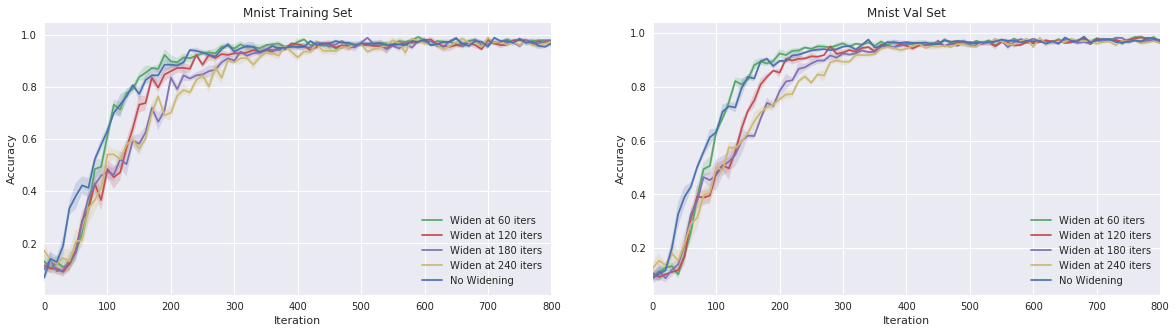

In [186]:
# Grab old results
plt.figure(figsize=(20,5))
plt.tight_layout()

xaxis = np.array(range(81)) * 10
old_results = []
old_results_val = []
for i in range(len(our_init_results)):
    old_results.append(our_init_results[i][:81])
    old_results_val.append(our_init_results_val[i][:81])
    
# Plot results
plt.subplot(121)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
cp = sns.color_palette("deep", 10)
sns.tsplot(data=widen_results[60], time=xaxis, color=cp[1], condition="Widen at 60 iters")
sns.tsplot(data=widen_results[120], time=xaxis, color=cp[2], condition="Widen at 120 iters")
sns.tsplot(data=widen_results[180], time=xaxis, color=cp[3], condition="Widen at 180 iters")
sns.tsplot(data=widen_results[240], time=xaxis, color=cp[4], condition="Widen at 240 iters")
sns.tsplot(data=widen_results[0], time=xaxis, color=cp[0], condition="Widen at 0 iters")
plt.legend()

plt.subplot(122)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=widen_results_val[60], time=xaxis, color=cp[1], condition="Widen at 60 iters")
sns.tsplot(data=widen_results_val[120], time=xaxis, color=cp[2], condition="Widen at 120 iters")
sns.tsplot(data=widen_results_val[180], time=xaxis, color=cp[3], condition="Widen at 180 iters")
sns.tsplot(data=widen_results_val[240], time=xaxis, color=cp[4], condition="Widen at 240 iters")
sns.tsplot(data=widen_results_val[0], time=xaxis, color=cp[0], condition="Widen at 0 iters")

### Initially implementing R2DeeperR, by (hacky) Mnist_Residual_Network_v3

We're going to alter the code from Mnist Residual Network v2. A hacky way to implement the deepen transform is to just keep all of the layers initialized at the start, and only use a subset of the layers before the "deepen" transform. Therefore, in this iteration, deepening the network will correspond to just setting a flag, and initializing the initially "None" layer.

For simplicity, we wrap the functions to widen and deepen the network as functions in the object, `widen` and `deepen`. As we're just using `widen` as a wrapper for `_widen_network_convs_scaled_`, we still need to implement the enum functions (noting that they *do* need to be changes from v2 to v3).

Note that we will implement this in a smarter way in our library code, however, this is sufficient (but hacky) way to be able to test and evaluate R2DeeperR.

Because a 6 residual block (i.e. 18 layer) network is a little overkill for Mnist, we reduce it to just 2 residual blocks before the deepen, and 4 after.

In [24]:
class Mnist_Resnet_v3(nn.Module):
    def __init__(self, identity_initialize=True, noise_ratio=1.0e-8):
        # Superclass initializer
        super(Mnist_Resnet_v3, self).__init__()
        
        self.identity_initialize = identity_initialize
        self.noise_ratio=noise_ratio
        
        # Make the three conv layers, with three max pools  
        self.resblock1 = R2R_residual_block_v2(input_channels=1, 
                                               output_channels=8, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio)                 # [-1, 8, 32, 32]
        self.pool1 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 8, 16, 16]  
        self.resblock2 = R2R_residual_block_v2(input_channels=8, 
                                               output_channels=16, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio)                 # [-1, 16, 16, 16]
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 16, 8, 8]  
        self.resblock3 = None
#         i, o = (32, 64) if not thin else (16, 32)
#         self.resblock3 = R2R_residual_block_v2(input_channels=16, 
#                                                output_channels=32, 
#                                                identity_initialize=identity_initialize,
#                                                noise_ratio=noise_ratio)               # [-1, 32, 8, 8]
        self.pool3 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 32, 4, 4]
        
        # fully connected out
        self.linear1 = nn.Linear(4*4*32, 256)
        self.linear2 = nn.Linear(256, 10)
        
    
    def forward(self, x):
        # convs
        x = self.resblock1(x)
        x = self.pool1(x)
        x = self.resblock2(x)
        x = self.pool2(x)
        if self.resblock3 is not None:
            x = self.resblock3(x)
        else:
            # if ignoring 3rd block, then make it an identity (v. hacky here...)
            buf_shape = x.size()
            buf_shape = (buf_shape[0], buf_shape[1]*2, buf_shape[2], buf_shape[3])
            buf = t.zeros(buf_shape)
            buf[:,:x.size()[1]] = x
            x = buf
            
        x = self.pool3(x)
        
        # fc
        x = _flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        
        return x
    
    
    def widen(self):
        """
        Wrapper for R2WiderR 
        """
        _widen_network_convs_scaled_(self, 2)
        
        
    def deepen(self):
        """
        Wrapper for R2DeeperR (this is a hacky implementation!)
        """
        in_channels = self.resblock2.r2r.conv2.weight.data.size(0)
        self.resblock3 = R2R_residual_block_v2(input_channels=in_channels, 
                                               output_channels=32, 
                                               identity_initialize=self.identity_initialize,
                                               noise_ratio=self.noise_ratio) # [-1, 64, 8, 8]
    
        
    def conv_enum(self):
        """
        Enumerate through all the conv layers (from network input to output)
        """
        inner_chain = self.resblock2.conv_enum() 
        if self.resblock3 is not None:
            inner_chain = chain(self.resblock2.conv_enum(), self.resblock3.conv_enum())
        return chain(self.resblock1.conv_enum(), inner_chain)
        
    
    def batch_norm_enum(self):
        """
        Enumerate through all the batch norm layers (from network input to output)
        """
        inner_chain = self.resblock2.batch_norm_enum() 
        if self.resblock3 is not None:
            inner_chain = chain(self.resblock2.batch_norm_enum(), self.resblock3.batch_norm_enum())
        return chain(self.resblock1.batch_norm_enum(), inner_chain)
    
    
    def fully_connected_enum(self):
        """
        Enumerate through all the fully connected layers (from network input to output)
        """
        yield self.linear1
        yield self.linear2

### Sanity check, for the deepen transform

Basically just a c&p from the check for the widen transform before. Note because of how we implemented the network, the number of parameters is the same before and after. 

Still, it's important that we check that we have implemented the function preserving transform correctly!!

In [25]:
# Make a mnist resnet v3
model = Mnist_Resnet_v3(noise_ratio=0.0)
params_before = sum([np.prod(p.size()) for p in model.parameters()])

# store 10 random inputs, and their outputs
rand_ins = []
rand_outs = []
for _ in range(10):
    rand_in = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,1,32,32)))
    rand_out = model(rand_in)
    rand_ins.append(rand_in)
    rand_outs.append(rand_out)

# widen and check that the outputs are (almost) identical
model.deepen()
params_after = sum([np.prod(p.size()) for p in model.parameters()])
for i in range(10):
    rand_out = model(rand_ins[i])
    print("Average output difference before and after widen is: %f" % t.mean(rand_out - rand_outs[i]))
    
print("Params in model before widen: %d" % params_before)
print("Params in model after widen: %d" % params_after)

Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Params in model before widen: 141442
Params in model after widen: 165826


### Testing the widen transfrom on mnist, and evaluating it

We now extend the evaluate function to take an iteration number to call deepen on the model. Evaluation then just consists of a training loop, where at some point we widen the network.

To compare fairly, will define a smallish network, and widen at different timesteps. Importantly, we consider "deepening at timestep 0", which is the same as a random initialization of a network of the "deepened network".

Note that this is essentially the same as how we evaluate the widening transform.

In [26]:
# evaluate a model that implements the .widen() and .deepen() functions
def evaluate(model, dataset, widen=-1, deepen=-1):
    # Setup bookeeping and optimizer
    train_iters = 800
    epoch_len = 10
    train_accuracies = []
    val_accuracies = []
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
    
    # train for 300 iterations, evaluating every epoch
    for i in range(train_iters+1):
        # if need to widen/deepen, apply the appropriate transform
        if i ==  widen:
            model.widen()
            optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
        if i == deepen: 
            model.deepen()
            optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
            
        # compute loss
        xs, ys = dataset.next_batch(64)
        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys)
        
        # make a step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # log at the beginning/end of every epoch
        if i % epoch_len == 0:
            train_acc = accuracy(ys_pred, ys)
            
            xs, ys = dataset.next_val_batch(128)
            ys_pred = model(xs)            
            val_acc = accuracy(ys_pred, ys)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            
            print("(Iter %d). Current train: %0.6f, Current val: %0.6f." % (i, train_acc, val_acc))
            
    return train_accuracies, val_accuracies

In [190]:
# run our init, with widen at 60,120,180,240 iters
deepen_results = {}
deepen_results_val = {}
deepen_times = {}

dataset = DatasetCudaWrapper(MnistDataset(64)) if use_gpu else MnistDataset(64)

for deepen in [0, 60,120,180,240]:
    results = []
    results_val = []
    times = []
    
    for i in range(5):
        model = Mnist_Resnet_v3()
        if use_gpu:
            model = model.cuda()
        start_time = time.time()
        train_acc, val_acc = evaluate(model, dataset, deepen=deepen)
        elapsed_time = time.time() - start_time
        
        results.append(train_acc)
        results_val.append(val_acc)
        times.append(elapsed_time)
        
    deepen_results[deepen] = results
    deepen_results_val[deepen] = results_val
    deepen_times[deepen] = (np.mean(times), np.std(times))

Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-labels-idx1-ubyte.gz
(Iter 0). Current train: 0.125000, Current val: 0.156250.
(Iter 10). Current train: 0.265625, Current val: 0.109375.
(Iter 20). Current train: 0.046875, Current val: 0.101562.
(Iter 30). Current train: 0.078125, Current val: 0.085938.
(Iter 40). Current train: 0.281250, Current val: 0.242188.
(Iter 50). Current train: 0.343750, Current val: 0.265625.
(Iter 60). Current train: 0.140625, C

(Iter 460). Current train: 0.921875, Current val: 0.953125.
(Iter 470). Current train: 0.968750, Current val: 0.968750.
(Iter 480). Current train: 0.984375, Current val: 0.960938.
(Iter 490). Current train: 0.984375, Current val: 0.984375.
(Iter 500). Current train: 0.953125, Current val: 0.968750.
(Iter 510). Current train: 0.953125, Current val: 0.968750.
(Iter 520). Current train: 0.984375, Current val: 0.984375.
(Iter 530). Current train: 1.000000, Current val: 0.960938.
(Iter 540). Current train: 0.968750, Current val: 0.976562.
(Iter 550). Current train: 0.953125, Current val: 0.968750.
(Iter 560). Current train: 0.968750, Current val: 0.960938.
(Iter 570). Current train: 0.953125, Current val: 0.992188.
(Iter 580). Current train: 0.968750, Current val: 0.953125.
(Iter 590). Current train: 0.953125, Current val: 0.968750.
(Iter 600). Current train: 1.000000, Current val: 0.984375.
(Iter 610). Current train: 0.953125, Current val: 0.992188.
(Iter 620). Current train: 1.000000, Cur

(Iter 210). Current train: 0.906250, Current val: 0.921875.
(Iter 220). Current train: 0.984375, Current val: 0.960938.
(Iter 230). Current train: 0.921875, Current val: 0.890625.
(Iter 240). Current train: 0.937500, Current val: 0.929688.
(Iter 250). Current train: 0.968750, Current val: 0.968750.
(Iter 260). Current train: 1.000000, Current val: 0.953125.
(Iter 270). Current train: 0.968750, Current val: 0.968750.
(Iter 280). Current train: 0.921875, Current val: 0.960938.
(Iter 290). Current train: 0.859375, Current val: 0.937500.
(Iter 300). Current train: 0.968750, Current val: 0.953125.
(Iter 310). Current train: 0.937500, Current val: 0.984375.
(Iter 320). Current train: 0.953125, Current val: 0.906250.
(Iter 330). Current train: 0.984375, Current val: 0.937500.
(Iter 340). Current train: 0.906250, Current val: 0.960938.
(Iter 350). Current train: 0.953125, Current val: 0.968750.
(Iter 360). Current train: 0.953125, Current val: 0.945312.
(Iter 370). Current train: 0.921875, Cur

(Iter 770). Current train: 0.968750, Current val: 0.984375.
(Iter 780). Current train: 0.968750, Current val: 0.960938.
(Iter 790). Current train: 0.953125, Current val: 0.968750.
(Iter 800). Current train: 1.000000, Current val: 0.976562.
(Iter 0). Current train: 0.046875, Current val: 0.031250.
(Iter 10). Current train: 0.046875, Current val: 0.085938.
(Iter 20). Current train: 0.125000, Current val: 0.101562.
(Iter 30). Current train: 0.156250, Current val: 0.195312.
(Iter 40). Current train: 0.156250, Current val: 0.195312.
(Iter 50). Current train: 0.234375, Current val: 0.156250.
(Iter 60). Current train: 0.218750, Current val: 0.218750.
(Iter 70). Current train: 0.140625, Current val: 0.289062.
(Iter 80). Current train: 0.515625, Current val: 0.484375.
(Iter 90). Current train: 0.609375, Current val: 0.515625.
(Iter 100). Current train: 0.500000, Current val: 0.406250.
(Iter 110). Current train: 0.593750, Current val: 0.710938.
(Iter 120). Current train: 0.593750, Current val: 0

(Iter 520). Current train: 0.968750, Current val: 0.976562.
(Iter 530). Current train: 0.937500, Current val: 0.976562.
(Iter 540). Current train: 0.984375, Current val: 0.984375.
(Iter 550). Current train: 1.000000, Current val: 0.968750.
(Iter 560). Current train: 1.000000, Current val: 0.976562.
(Iter 570). Current train: 1.000000, Current val: 0.984375.
(Iter 580). Current train: 0.984375, Current val: 0.953125.
(Iter 590). Current train: 0.968750, Current val: 0.968750.
(Iter 600). Current train: 0.984375, Current val: 0.968750.
(Iter 610). Current train: 0.968750, Current val: 0.953125.
(Iter 620). Current train: 0.953125, Current val: 0.992188.
(Iter 630). Current train: 0.984375, Current val: 0.968750.
(Iter 640). Current train: 0.968750, Current val: 0.976562.
(Iter 650). Current train: 0.984375, Current val: 0.976562.
(Iter 660). Current train: 1.000000, Current val: 0.992188.
(Iter 670). Current train: 0.968750, Current val: 0.968750.
(Iter 680). Current train: 1.000000, Cur

(Iter 270). Current train: 0.968750, Current val: 0.953125.
(Iter 280). Current train: 0.937500, Current val: 0.953125.
(Iter 290). Current train: 0.906250, Current val: 0.953125.
(Iter 300). Current train: 0.968750, Current val: 0.953125.
(Iter 310). Current train: 0.953125, Current val: 0.960938.
(Iter 320). Current train: 0.953125, Current val: 0.937500.
(Iter 330). Current train: 0.937500, Current val: 0.960938.
(Iter 340). Current train: 0.984375, Current val: 0.945312.
(Iter 350). Current train: 0.921875, Current val: 0.945312.
(Iter 360). Current train: 0.953125, Current val: 0.945312.
(Iter 370). Current train: 0.968750, Current val: 0.929688.
(Iter 380). Current train: 0.984375, Current val: 0.976562.
(Iter 390). Current train: 0.937500, Current val: 0.984375.
(Iter 400). Current train: 1.000000, Current val: 0.937500.
(Iter 410). Current train: 0.921875, Current val: 0.937500.
(Iter 420). Current train: 0.953125, Current val: 0.953125.
(Iter 430). Current train: 0.984375, Cur

(Iter 20). Current train: 0.203125, Current val: 0.125000.
(Iter 30). Current train: 0.187500, Current val: 0.226562.
(Iter 40). Current train: 0.187500, Current val: 0.125000.
(Iter 50). Current train: 0.171875, Current val: 0.187500.
(Iter 60). Current train: 0.218750, Current val: 0.195312.
(Iter 70). Current train: 0.296875, Current val: 0.320312.
(Iter 80). Current train: 0.359375, Current val: 0.375000.
(Iter 90). Current train: 0.312500, Current val: 0.398438.
(Iter 100). Current train: 0.562500, Current val: 0.500000.
(Iter 110). Current train: 0.578125, Current val: 0.453125.
(Iter 120). Current train: 0.484375, Current val: 0.500000.
(Iter 130). Current train: 0.531250, Current val: 0.500000.
(Iter 140). Current train: 0.515625, Current val: 0.648438.
(Iter 150). Current train: 0.656250, Current val: 0.625000.
(Iter 160). Current train: 0.640625, Current val: 0.687500.
(Iter 170). Current train: 0.750000, Current val: 0.734375.
(Iter 180). Current train: 0.718750, Current val

(Iter 580). Current train: 1.000000, Current val: 0.960938.
(Iter 590). Current train: 0.984375, Current val: 0.984375.
(Iter 600). Current train: 0.968750, Current val: 0.984375.
(Iter 610). Current train: 0.968750, Current val: 0.953125.
(Iter 620). Current train: 0.968750, Current val: 0.992188.
(Iter 630). Current train: 0.953125, Current val: 0.968750.
(Iter 640). Current train: 0.984375, Current val: 0.992188.
(Iter 650). Current train: 0.984375, Current val: 0.992188.
(Iter 660). Current train: 0.968750, Current val: 0.992188.
(Iter 670). Current train: 0.968750, Current val: 0.992188.
(Iter 680). Current train: 0.984375, Current val: 0.976562.
(Iter 690). Current train: 0.984375, Current val: 0.968750.
(Iter 700). Current train: 0.953125, Current val: 0.984375.
(Iter 710). Current train: 0.968750, Current val: 0.976562.
(Iter 720). Current train: 0.984375, Current val: 0.953125.
(Iter 730). Current train: 0.984375, Current val: 0.968750.
(Iter 740). Current train: 1.000000, Cur

(Iter 330). Current train: 0.984375, Current val: 0.953125.
(Iter 340). Current train: 0.968750, Current val: 0.914062.
(Iter 350). Current train: 0.890625, Current val: 0.937500.
(Iter 360). Current train: 0.968750, Current val: 0.921875.
(Iter 370). Current train: 0.937500, Current val: 0.937500.
(Iter 380). Current train: 0.906250, Current val: 0.914062.
(Iter 390). Current train: 0.921875, Current val: 0.937500.
(Iter 400). Current train: 0.890625, Current val: 0.921875.
(Iter 410). Current train: 0.890625, Current val: 0.976562.
(Iter 420). Current train: 0.968750, Current val: 0.968750.
(Iter 430). Current train: 0.953125, Current val: 0.976562.
(Iter 440). Current train: 0.968750, Current val: 0.968750.
(Iter 450). Current train: 0.921875, Current val: 0.921875.
(Iter 460). Current train: 0.968750, Current val: 0.945312.
(Iter 470). Current train: 0.937500, Current val: 0.953125.
(Iter 480). Current train: 0.968750, Current val: 0.968750.
(Iter 490). Current train: 0.937500, Cur

(Iter 80). Current train: 0.437500, Current val: 0.468750.
(Iter 90). Current train: 0.562500, Current val: 0.515625.
(Iter 100). Current train: 0.703125, Current val: 0.609375.
(Iter 110). Current train: 0.593750, Current val: 0.625000.
(Iter 120). Current train: 0.609375, Current val: 0.531250.
(Iter 130). Current train: 0.484375, Current val: 0.625000.
(Iter 140). Current train: 0.687500, Current val: 0.632812.
(Iter 150). Current train: 0.640625, Current val: 0.679688.
(Iter 160). Current train: 0.734375, Current val: 0.679688.
(Iter 170). Current train: 0.750000, Current val: 0.789062.
(Iter 180). Current train: 0.765625, Current val: 0.765625.
(Iter 190). Current train: 0.828125, Current val: 0.796875.
(Iter 200). Current train: 0.859375, Current val: 0.843750.
(Iter 210). Current train: 0.875000, Current val: 0.812500.
(Iter 220). Current train: 0.828125, Current val: 0.851562.
(Iter 230). Current train: 0.859375, Current val: 0.906250.
(Iter 240). Current train: 0.843750, Curre

(Iter 640). Current train: 0.968750, Current val: 0.929688.
(Iter 650). Current train: 0.937500, Current val: 0.968750.
(Iter 660). Current train: 0.984375, Current val: 0.992188.
(Iter 670). Current train: 0.984375, Current val: 0.984375.
(Iter 680). Current train: 0.953125, Current val: 0.992188.
(Iter 690). Current train: 1.000000, Current val: 0.937500.
(Iter 700). Current train: 0.937500, Current val: 0.984375.
(Iter 710). Current train: 0.984375, Current val: 1.000000.
(Iter 720). Current train: 1.000000, Current val: 0.976562.
(Iter 730). Current train: 0.937500, Current val: 0.976562.
(Iter 740). Current train: 0.968750, Current val: 0.976562.
(Iter 750). Current train: 0.968750, Current val: 0.960938.
(Iter 760). Current train: 0.984375, Current val: 0.968750.
(Iter 770). Current train: 0.968750, Current val: 0.968750.
(Iter 780). Current train: 0.921875, Current val: 0.968750.
(Iter 790). Current train: 0.984375, Current val: 0.984375.
(Iter 800). Current train: 0.968750, Cur

(Iter 390). Current train: 0.937500, Current val: 0.968750.
(Iter 400). Current train: 0.906250, Current val: 0.914062.
(Iter 410). Current train: 0.921875, Current val: 0.953125.
(Iter 420). Current train: 0.937500, Current val: 0.937500.
(Iter 430). Current train: 0.906250, Current val: 0.921875.
(Iter 440). Current train: 0.953125, Current val: 0.953125.
(Iter 450). Current train: 0.953125, Current val: 0.976562.
(Iter 460). Current train: 0.984375, Current val: 0.937500.
(Iter 470). Current train: 0.937500, Current val: 0.968750.
(Iter 480). Current train: 0.984375, Current val: 0.945312.
(Iter 490). Current train: 0.953125, Current val: 0.914062.
(Iter 500). Current train: 0.906250, Current val: 0.976562.
(Iter 510). Current train: 0.984375, Current val: 0.968750.
(Iter 520). Current train: 0.937500, Current val: 0.953125.
(Iter 530). Current train: 0.953125, Current val: 0.953125.
(Iter 540). Current train: 0.984375, Current val: 0.968750.
(Iter 550). Current train: 0.953125, Cur

### Plotting the results (with respect to number of updates) of using R2DeeperR at different times

We've run the eval loop on many networks, calling the deepen() transform at differing stages of training to see what effect it has. So now we plot the results.

Note that this is NOT representative of how long the models took to train. Updates on the smaller models are MUCH quicker. So it will look like the smaller networks did worst, but, they actually trained quicker, hitting the same performance.

/anaconda/envs/cs231n/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


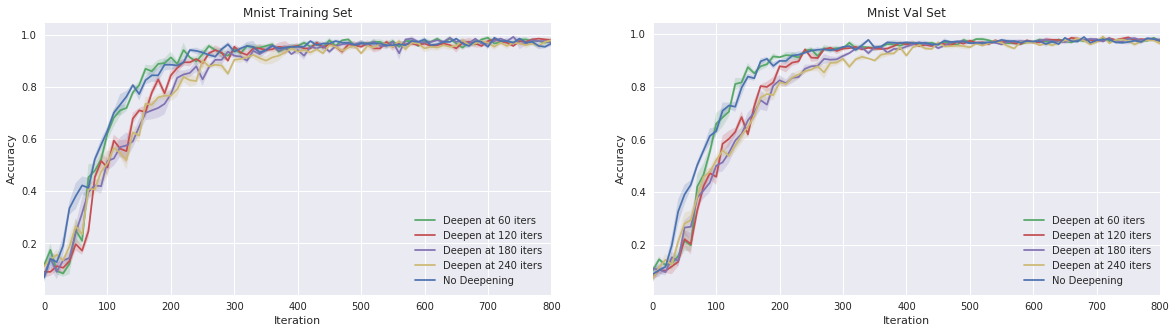

In [191]:
# Plot results
plt.figure(figsize=(20,5))
plt.tight_layout()

xaxis = np.array(range(81)) * 10

plt.subplot(121)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
cp = sns.color_palette("deep", 10)
sns.tsplot(data=deepen_results[60], time=xaxis, color=cp[1], condition="Deepen at 60 iters")
sns.tsplot(data=deepen_results[120], time=xaxis, color=cp[2], condition="Deepen at 120 iters")
sns.tsplot(data=deepen_results[180], time=xaxis, color=cp[3], condition="Deepen at 180 iters")
sns.tsplot(data=deepen_results[240], time=xaxis, color=cp[4], condition="Deepen at 240 iters")
sns.tsplot(data=deepen_results[0], time=xaxis, color=cp[0], condition="Deepen at 0 iters")
plt.legend()

plt.subplot(122)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=deepen_results_val[60], time=xaxis, color=cp[1], condition="Deepen at 60 iters")
sns.tsplot(data=deepen_results_val[120], time=xaxis, color=cp[2], condition="Deepen at 120 iters")
sns.tsplot(data=deepen_results_val[180], time=xaxis, color=cp[3], condition="Deepen at 180 iters")
sns.tsplot(data=deepen_results_val[240], time=xaxis, color=cp[4], condition="Deepen at 240 iters")
sns.tsplot(data=deepen_results_val[0], time=xaxis, color=cp[0], condition="Deepen at 0 iters")

## Counting FLOPs
### Beginning with some basic FLOP counting computations

An important way to evaluate how much computation time training takes will be to "count floating point operations (FLOPs)".

`model.compute_average_flops_cost()` will compute the number of floating point operations that were used to compute the forward and backward pass of the model. We can then compare the number of floating point operations required for models to converge. Interesting comparisons will hopefully be able to be made 

FLOPs is important rather than counting time elapsed to account for randomness in scheduling and different computer architectures that people may use.

Computing the number of FLOPs is complex, and not very relevant to what we're talking about in `tutorial.py`. Therefore, we keep all of the code in a seperate `flops_utils.py`. An interested reader can look at this file to see how FLOPs counting is implemented.

Note that the v3 net, after a widen and deepen is identical to the v1 net, which can be reflected in the number of parameters in the network output below.

In [28]:
from utils.flops_utils import *
from dataset import MnistDataset

dataset = DatasetCudaWrapper(MnistDataset(32)) if use_gpu else MnistDataset(32)
xs, _ = dataset.next_batch()

model = Mnist_Resnet_v3()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
thin_shallow_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v3()
model.widen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
wide_shallow_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v3()
model.deepen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
thin_deep_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v3()
model.deepen()
model.widen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
wide_deep_flops = model.compute_average_flops_cost()

baseline_model = Mnist_Resnet_v1()
baseline_model = add_flops_counting_methods(baseline_model)
baseline_model.start_flops_count()

_ = baseline_model(xs)
baseline_flops = model.compute_average_flops_cost()

print("v1 flops: %d" % baseline_flops)
print("v3 thin, shallow flops: %d" % thin_shallow_flops)
print("v3 thin, deeper flops: %d" % thin_deep_flops)
print("v3 wider, shallow flops: %d" % wide_shallow_flops)
print("v3 wider, deeper flops: %d" % wide_deep_flops)

Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/t10k-labels-idx1-ubyte.gz
v1 flops: 34748416
v3 thin, shallow flops: 5767168
v3 thin, deeper flops: 8855552
v3 wider, shallow flops: 22409216
v3 wider, deeper flops: 34748416


### Plotting training results with respect to FLOPs

As we can now compute the number of FLOPs used for each network update, we can scale the x axes appropriately, so that the x axis is proportional to the time spent training.

Taking FLOPs into account, we see that training on smaller networks first leads to faster training times, as can be observed directly!

There's quite a bit of code here, but, really it's just re-scaling the x-axes on the plots as we describe above!

In [ ]:
from flops_utils import *

dataset = DatasetCudaWrapper(MnistDataset(64)) if use_gpu else MnistDataset(64)
xs, _ = dataset.next_batch(64)

model = Mnist_Resnet_v3(thin=False)
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
pre_deepen_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v3(thin=False)
model.deepen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
post_deepen_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v2(thin=True)
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
pre_widen_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v2(thin=True)
model.widen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
post_widen_flops = model.compute_average_flops_cost()

baseline_model = Mnist_Resnet_v1()
baseline_model = add_flops_counting_methods(baseline_model)
baseline_model.start_flops_count()

_ = baseline_model(xs)
baseline_flops = baseline_model.compute_average_flops_cost()


expansion_times_div_ten = [6,12,18,24]
train_iters_div_ten = 80

baseline_flopss = [i*10*baseline_flops for i in range(train_iters_div_ten+1)]
widen_flops = {}
for widen_div_ten in expansion_times_div_ten:
    flops_one = [i*10*pre_widen_flops for i in range(widen_div_ten+1)] 
    flops_two = [flops_one[-1] + i*10*post_widen_flops for i in range(1,train_iters_div_ten+1-widen_div_ten)]
    widen_flops[widen_div_ten*10] = flops_one + flops_two
deepen_flops = {}
for deepen_div_ten in expansion_times_div_ten:
    flops_one = [i*10*pre_deepen_flops for i in range(deepen_div_ten+1)] 
    flops_two = [flops_one[-1] + i*10*post_deepen_flops for i in range(1,train_iters_div_ten+1-deepen_div_ten)]
    deepen_flops[deepen_div_ten*10] = flops_one + flops_two
    

old_results_label = "No Deepening. (%.1f +/- %.1f)" % (our_init_mean_time, our_init_stddev_time)
widen_labels = []
for i_div_ten in expansion_times_div_ten:
    i = 10 * i_div_ten
    widen_labels.append("Widen at %d iters. (%.1f +/- %.1f)" % (i, widen_times[i][0], widen_times[i][1]))
deepen_labels = []
for i_div_ten in expansion_times_div_ten:
    i = 10 * i_div_ten
    deepen_labels.append("Deepen at %d iters. (%.1f +/- %.1f)" % (i, deepen_times[i][0], deepen_times[i][1]))
    

# Plot results
plt.figure(figsize=(20,10))
#plt.tight_layout()

plt.subplot(221)
plt.xlabel('Floating Point Operations')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
cp = sns.color_palette("deep", 10)
sns.tsplot(data=deepen_results[60], time=deepen_flops[60], color=cp[1], condition=deepen_labels[0])
sns.tsplot(data=deepen_results[120], time=deepen_flops[120], color=cp[2], condition=deepen_labels[1])
sns.tsplot(data=deepen_results[180], time=deepen_flops[180], color=cp[3], condition=deepen_labels[2])
sns.tsplot(data=deepen_results[240], time=deepen_flops[240], color=cp[4], condition=deepen_labels[3])
sns.tsplot(data=old_results, time=baseline_flopss, color=cp[0], condition=old_results_label)
plt.legend()

plt.subplot(222)
plt.xlabel('Floating Point Operations')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=deepen_results_val[60], time=deepen_flops[60], color=cp[1], condition=deepen_labels[0])
sns.tsplot(data=deepen_results_val[120], time=deepen_flops[120], color=cp[2], condition=deepen_labels[1])
sns.tsplot(data=deepen_results_val[180], time=deepen_flops[180], color=cp[3], condition=deepen_labels[2])
sns.tsplot(data=deepen_results_val[240], time=deepen_flops[240], color=cp[4], condition=deepen_labels[3])
sns.tsplot(data=old_results_val, time=baseline_flopss, color=cp[0], condition=old_results_label)


plt.tight_layout()
plt.subplot(223)
plt.xlabel('Floating Point Operations')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
cp = sns.color_palette("deep", 10)
sns.tsplot(data=deepen_results[60], time=widen_flops[60], color=cp[1], condition=widen_labels[0])
sns.tsplot(data=deepen_results[120], time=widen_flops[120], color=cp[2], condition=widen_labels[1])
sns.tsplot(data=deepen_results[180], time=widen_flops[180], color=cp[3], condition=widen_labels[2])
sns.tsplot(data=deepen_results[240], time=widen_flops[240], color=cp[4], condition=widen_labels[3])
sns.tsplot(data=old_results, time=baseline_flopss, color=cp[0], condition=old_results_label)
plt.legend()

plt.subplot(224)
plt.xlabel('Floating Point Operations')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=widen_results_val[60], time=widen_flops[60], color=cp[1], condition=widen_labels[0])
sns.tsplot(data=widen_results_val[120], time=widen_flops[120], color=cp[2], condition=widen_labels[1])
sns.tsplot(data=widen_results_val[180], time=widen_flops[180], color=cp[3], condition=widen_labels[2])
sns.tsplot(data=widen_results_val[240], time=widen_flops[240], color=cp[4], condition=widen_labels[3]) 
sns.tsplot(data=old_results_val, time=baseline_flopss, color=cp[0], condition=old_results_label)

plt.tight_layout()

## Visualizing weights

Here we will train, and widen a network a few times. At different timesteps we will visualize the weights of the first layer of the network.

To make the vizualizations easier to see, we define a R2R_Mnist_Resnet_v4, which uses a larger kernel size for its first layer.

Really, this is a sanity check that the additional channels that we're introducing into the network are actually learning something relevant, and not just ignored by the network or introducing some unnoticable high frequency noise.

### v4
Just to make the visualizations a little nicer, we're going to define a small residual block v4 and residual network v4, where the first layer is a $7\times 7$ convolution. Moreover, we're going to make this first layer only have a small number of channels to visualize, so as not to be overwhelming.

In [29]:
# Global constant to control the number of filters being visualized
num_filters_to_visualize = 4

In [30]:
class R2R_residual_block_v4(R2R_residual_block_v2):
    """
    R2R_residual_block_v4 just changes self.conv1 and self.conv2. The rest of the code still works :)
    Specifially, we use num_filters_to_visualize/2 filters, which will be extended to num_filters_to_visualize 
    filters by the widening function.
    """
    def __init__(self, input_channels, output_channels, identity_initialize=True, noise_ratio=1.0e-8):
        super(R2R_residual_block_v2, self).__init__(input_channels, output_channels, identity_initialize, 
                                                    noise_ratio)
        self.conv1 = nn.Conv2d(input_channels, num_filters_to_visualize//2, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm2d(num_features=num_filters_to_visualize//2)
        self.conv2 = nn.Conv2d(num_filters_to_visualize//2, output_channels, kernel_size=3, padding=1)
        
        
class Mnist_Resnet_v4(Mnist_Resnet_v3):
    """
    Mnist_Resnet_v4 will just alter the first residual block to be a v4 rather than v2
    """
    def __init__(self, identity_initialize=True, noise_ratio=1.0e-8):
        super(Mnist_Resnet_v4, self).__init__(identity_initialize=identity_initialize, noise_ratio=noise_ratio)
        
        
        # Make the three conv layers, with three max pools  
        self.pool1 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 1, 16, 16] 
        self.resblock1 = R2R_residual_block_v4(input_channels=1, 
                                               output_channels=2, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio)                 # [-1, 2, 16, 16] 
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 2, 8, 8]  
        self.resblock2 = R2R_residual_block_v2(input_channels=2, 
                                               output_channels=2, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio)                 # [-1, 2, 8, 8]
        self.pool3 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 2, 4, 4]
        
        # fully connected out
        self.linear1 = nn.Linear(32, 10)
        
    
    def forward(self, x):
        # convs
        x = self.pool1(x)
        x = self.resblock1(x)
        x = self.pool2(x)
#         x = self.resblock2(x)
        x = self.pool3(x)
        
        # fc
        x = _flatten(x)
        x = self.linear1(x)
        
        return x
    
    
    def widen(self):
        """
        Wrapper for R2WiderR 
        """
        _widen_network_convs_scaled_(self, 2)
    
        
    def conv_enum(self):
        """
        Enumerate through all the conv layers (from network input to output)
        """
        return self.resblock1.conv_enum()
#         return chain(self.resblock1.conv_enum(), self.resblock2.conv_enum() )
        
    
    def batch_norm_enum(self):
        """
        Enumerate through all the batch norm layers (from network input to output)
        """
        return chain(self.resblock1.batch_norm_enum(), self.resblock2.batch_norm_enum() )
    
    
    def fully_connected_enum(self):
        """
        Enumerate through all the fully connected layers (from network input to output)
        """
        yield self.linear1

### Viz time

Now we will just define a training loop, similar to `evaluate` before. We'll set veriables to decide how many iterations to train for, how often to visualize the weights in the first layer and how long to train for. 

In [31]:
# variables defining how long to train for etc
train_iters = 2500
widen_at = 500
visualize_every = 50
epoch_len = 50

quiet_acc = False

visualize_width = num_filters_to_visualize
visualize_height = train_iters // visualize_every
total_plots = visualize_width * visualize_height

In [36]:
# helper to plot weights from the first layer of a Mnist_resnet_v4 to a figure
# we scale all of the weights to be in [0,1] for plotting. Rows will be consistently scaled, collumns won't.
def plot_weights(model, row):
    weights = model.resblock1.conv1.weight.data.cpu().numpy()
    minimum, maximum = np.min(weights, axis=(1,2,3), keepdims=True), np.max(weights, axis=(1,2,3), keepdims=True)
    weights = (weights - minimum) / (maximum - minimum)
    channels = weights.shape[0]
    for c in range(channels):
        plt.subplot(1, channels, c+1)
        plt.imshow(weights[c][0], cmap='Greys')
    plt.show()

# train a model, widening it at some point, and visualizing it every so often
def visualize_weights(model, dataset):
    # Setup optimizer
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
    
    # train for however long, and evaluate every 'epoch_len' updates
    for i in range(train_iters+1):
        # if need to widen/deepen, apply the appropriate transform
        if i ==  widen_at:
            model.widen()
            optimizer = t.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
            
        # Plot weights if timing is correct
        if i % visualize_every == 0:
            plot_weights(model, i // visualize_every)
            
        # compute loss
        xs, ys = dataset.next_batch(64)
        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys)
        
        # make a step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # log at the beginning/end of every epoch
        if i % epoch_len == 0:
            train_acc = accuracy(ys_pred, ys)
            
            xs, ys = dataset.next_val_batch(128)
            ys_pred = model(xs)            
            val_acc = accuracy(ys_pred, ys)
            
            if not quiet_acc:
                print("(Iter %d). Current train: %0.6f, Current val: %0.6f." % (i, train_acc, val_acc))

Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/t10k-labels-idx1-ubyte.gz


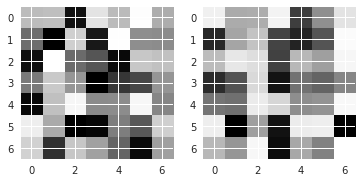

(Iter 0). Current train: 0.062500, Current val: 0.062500.


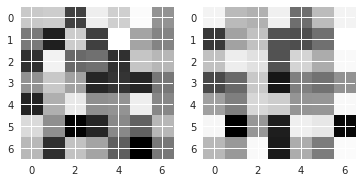

(Iter 50). Current train: 0.062500, Current val: 0.070312.


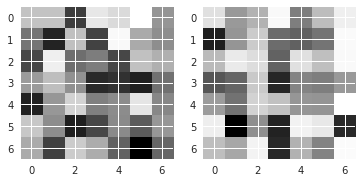

(Iter 100). Current train: 0.250000, Current val: 0.382812.


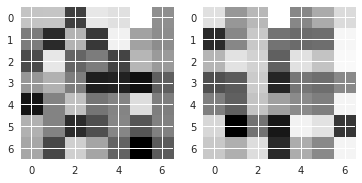

(Iter 150). Current train: 0.343750, Current val: 0.445312.


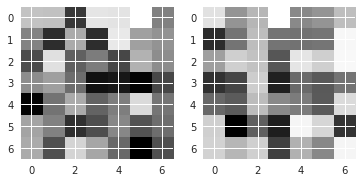

(Iter 200). Current train: 0.468750, Current val: 0.554688.


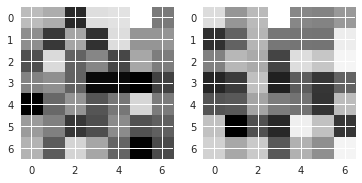

(Iter 250). Current train: 0.640625, Current val: 0.671875.


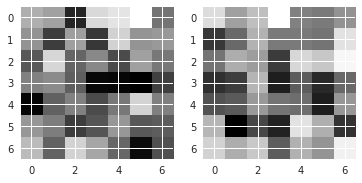

(Iter 300). Current train: 0.859375, Current val: 0.765625.


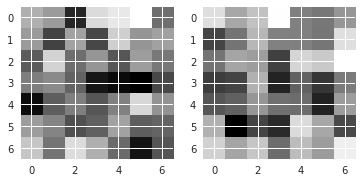

(Iter 350). Current train: 0.765625, Current val: 0.781250.


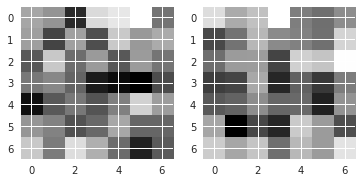

(Iter 400). Current train: 0.671875, Current val: 0.835938.


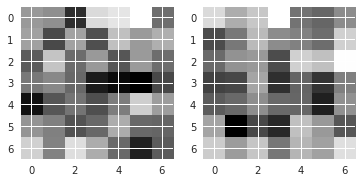

(Iter 450). Current train: 0.718750, Current val: 0.820312.


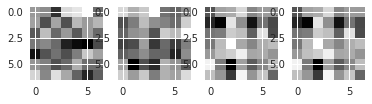

(Iter 500). Current train: 0.828125, Current val: 0.375000.


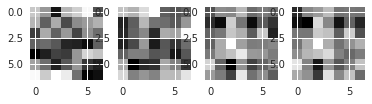

(Iter 550). Current train: 0.718750, Current val: 0.851562.


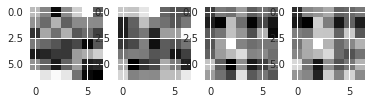

(Iter 600). Current train: 0.828125, Current val: 0.781250.


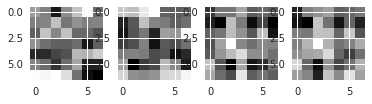

(Iter 650). Current train: 0.812500, Current val: 0.898438.


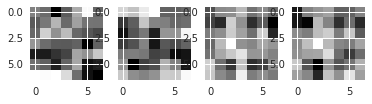

(Iter 700). Current train: 0.859375, Current val: 0.898438.


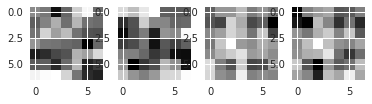

(Iter 750). Current train: 0.828125, Current val: 0.859375.


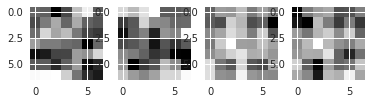

(Iter 800). Current train: 0.984375, Current val: 0.914062.


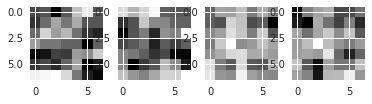

(Iter 850). Current train: 0.937500, Current val: 0.921875.


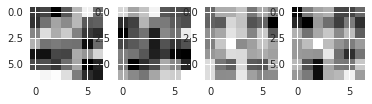

(Iter 900). Current train: 0.937500, Current val: 0.929688.


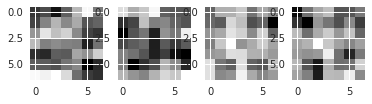

(Iter 950). Current train: 0.937500, Current val: 0.898438.


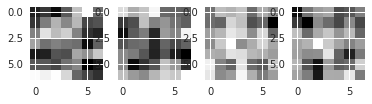

(Iter 1000). Current train: 0.921875, Current val: 0.937500.


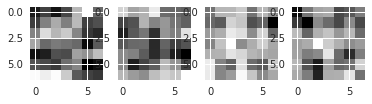

(Iter 1050). Current train: 0.953125, Current val: 0.929688.


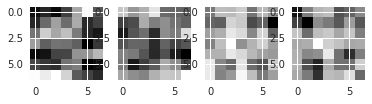

(Iter 1100). Current train: 0.953125, Current val: 0.937500.


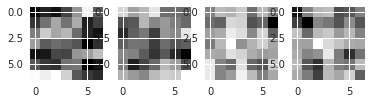

(Iter 1150). Current train: 0.953125, Current val: 0.914062.


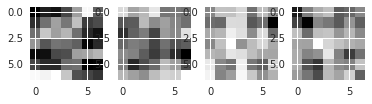

(Iter 1200). Current train: 0.953125, Current val: 0.906250.


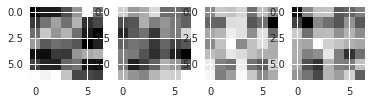

(Iter 1250). Current train: 0.828125, Current val: 0.937500.


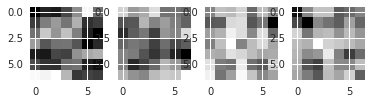

(Iter 1300). Current train: 0.921875, Current val: 0.921875.


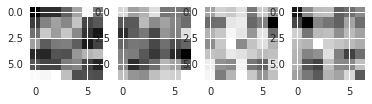

(Iter 1350). Current train: 0.937500, Current val: 0.921875.


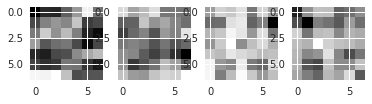

(Iter 1400). Current train: 0.953125, Current val: 0.906250.


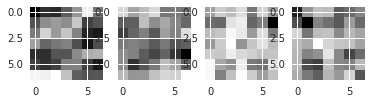

(Iter 1450). Current train: 0.937500, Current val: 0.968750.


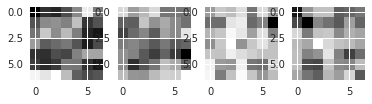

(Iter 1500). Current train: 0.921875, Current val: 0.937500.


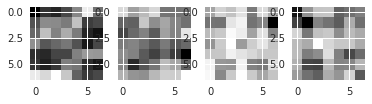

(Iter 1550). Current train: 0.968750, Current val: 0.937500.


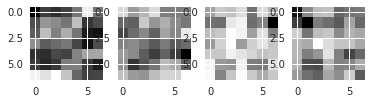

(Iter 1600). Current train: 1.000000, Current val: 0.937500.


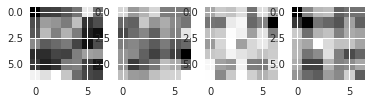

(Iter 1650). Current train: 0.906250, Current val: 0.921875.


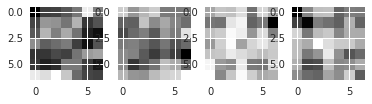

(Iter 1700). Current train: 0.953125, Current val: 0.914062.


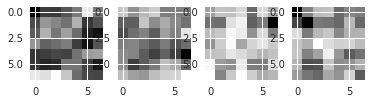

(Iter 1750). Current train: 0.906250, Current val: 0.976562.


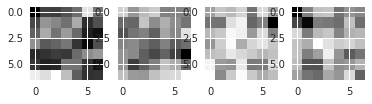

(Iter 1800). Current train: 0.968750, Current val: 0.953125.


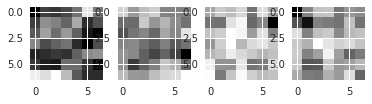

(Iter 1850). Current train: 0.953125, Current val: 0.968750.


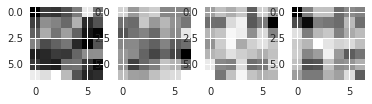

(Iter 1900). Current train: 0.921875, Current val: 0.953125.


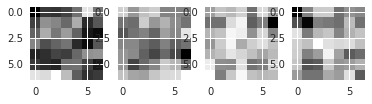

(Iter 1950). Current train: 0.937500, Current val: 0.953125.


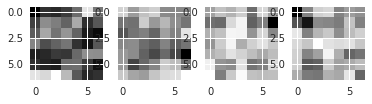

(Iter 2000). Current train: 0.953125, Current val: 0.953125.


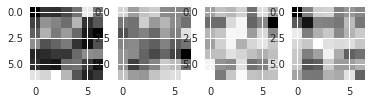

(Iter 2050). Current train: 0.968750, Current val: 0.921875.


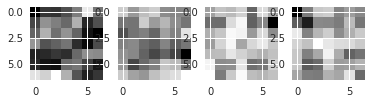

(Iter 2100). Current train: 0.968750, Current val: 0.921875.


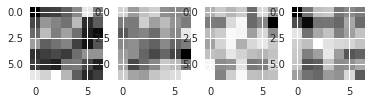

(Iter 2150). Current train: 0.968750, Current val: 0.968750.


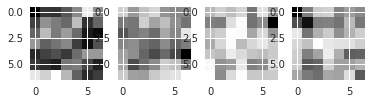

(Iter 2200). Current train: 0.984375, Current val: 0.960938.


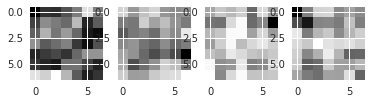

(Iter 2250). Current train: 0.968750, Current val: 0.937500.


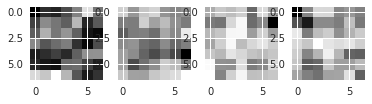

(Iter 2300). Current train: 0.953125, Current val: 0.937500.


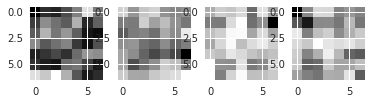

(Iter 2350). Current train: 0.984375, Current val: 0.937500.


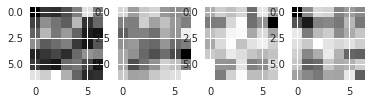

(Iter 2400). Current train: 0.875000, Current val: 0.960938.


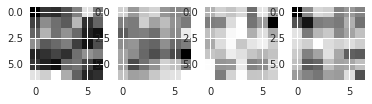

(Iter 2450). Current train: 0.937500, Current val: 0.953125.


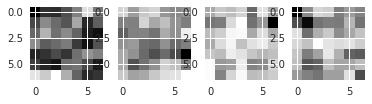

(Iter 2500). Current train: 0.937500, Current val: 0.937500.


In [37]:
# Go, go, go!
model = Mnist_Resnet_v4()
if use_gpu:
    model = model.cuda()
dataset = DatasetCudaWrapper(MnistDataset(64)) if use_gpu else MnistDataset(64)

visualize_weights(model, dataset)

## But what about Fully Connected Layer, implementing R2WiderR, with fully connected layers

We've ignored fully connected layers for now, and this has largely been because we can re-use almost all of the code above to implement it, if we're clever with shaping :)

We can make an observation that a fully connected layer is a special case of a convolutional layer, where the spatial dimensions of our input and output volumes are one, and our kernal is one. That is, if we have an inpuy with shape $(A)$ and output shape $(B)$, then the matrix for the weights of the fully connected layer must have shape $(B,A)$. 

Now, consider an input volume with shape $(A,1,1)$, output volume with shape $(B,1,1)$ and a convolutional kernel of $(B,A,1,1)$. Hopefully the correspondance is obvious :) 

Now, why are we considering only R2WiderR? Because R2DeeperR requires no non-obvious change to be made.

### Computing the new weights
We begin by implementing the equivelent of `_extend_filter_with_repeated_out_channels` and `_extend_filter_with_repeated_in_channels` for linear layers. 

In [77]:
def _extend_matrix_helper(extend_fn, extending_matrix_shape, existing_matrix=None, init_type='He', alpha=1.0):
    """
    _extend_matrix_with_repeated_out_weights and _extend_matrix_with_repeated_in_weights have exactly the same
    structure, except one calls _extend_filter_with_repeated_out_channels recursively, and the other 
    calls _extend_filter_with_repeated_in_channels recursively.
    
    extend_fn is appropriately set to _extend_filter_with_repeated_out_channels or 
    _extend_filter_with_repeated_in_channels
    """
    n_out, n_in = extending_matrix_shape
    psuedo_extending_filter_shape = (n_out,n_in,1,1)
    
    psuedo_existing_filter = existing_matrix
    if psuedo_existing_filter is not None:
        psuedo_existing_filter = np.expand_dims(np.expand_dims(psuedo_existing_filter, axis=2), axis=3)
    
    widened_psuedo_filter = extend_fn(psuedo_extending_filter_shape, psuedo_existing_filter, init_type, alpha)
    
    return np.squeeze(widened_psuedo_filter)
    

def _extend_matrix_with_repeated_out_weights(extending_matrix_shape, existing_matrix=None, 
                                              init_type='He', alpha=1.0):
    """
    Re-implement _extend_filter_with_repeated_out_channels, but for fully connected layers.
    We can reshape our inputs to just re-use _extend_filter_with_repeated_out_channels.
    
    :param extending_matrix_shape: The shape of the matrix for which we wish to to the existing matrix
    :param existing_matrix: The existing weights of a linear layer (can be None to initialize a new matrix with
            duplicated weights)
    :param init_type: The type of initialization to use for the new weights.
    :param alpha: The coefficient of the repeated weights
    :return: The new, widened matrix for the fully connected layer
    """
    return _extend_matrix_helper(_extend_filter_with_repeated_out_channels, extending_matrix_shape, 
                                 existing_matrix, init_type, alpha)
    

def _extend_matrix_with_repeated_in_weights(extending_matrix_shape, existing_matrix=None, 
                                              init_type='He', alpha=1.0):
    """
    Re-implement _extend_filter_with_repeated_in_channels, but for fully connected layers.
    We can reshape our inputs to just re-use _extend_filter_with_repeated_in_channels.
    
    :param extending_matrix_shape: The shape of the matrix for which we wish to to the existing matrix
    :param existing_matrix: The existing weights of a linear layer (can be None to initialize a new matrix with
            duplicated weights)
    :param init_type: The type of initialization to use for the new weights.
    :param alpha: The coefficient of the repeated weights
    :return: The new, widened matrix for the fully connected layer
    """
    return _extend_matrix_helper(_extend_filter_with_repeated_in_channels, extending_matrix_shape, 
                                 existing_matrix, init_type, alpha)

### Finishing it off
Now we just need to do the following three things, and we have then finished integrating our 
1. Implement a function that alters a linear layer, inline, to widen either the number of inputs or outputs of the layer. (I.e. the bit that fidles around with the PyTorch internals to assign new weights in the model)
2. Implement the general R2WiderR, which considers the following three pairs of layers conv -> conv, conv -> fc and fc -> fc. (I.e. the bit which extracts the weights, calls the extend functions above and returns the new weights).
3. Tie it all together using a function to iterate through all of the layers of the network, including, fully connected.
    1. Note... this *may* require us to be a little more clever with our batch norm iterables 

We implement these three things below.

In [110]:
def _assign_weights_and_bias_to_linear_(linear, matrix, bias=None):
    """
    Given a linear nn.Module, 'linear', we assign 'matrix' to the weights of that linear layer, 
    and if not none, we assign 'bias' to be the bias of 'linear'.
    
    If 'bias' is none, then we assume the current bias (with it's current shape) is safe to use. 
    If we are increasing the number of outputs from the hidden layer, then we must assign a new (probably zero 
    padded) bias.
    
    :param linear: An instance of nn.Linear to assign the kernel to
    :param matrix: A numpy tensor to assign to linear.weight
    :param bias: A numpy tensor to assign to linear.bias.
    :return: A reference to the updated linear layer
    """
    # If bias is none, we assume we can safely re-assign the old bias
    if bias is None:
        bias = linear.bias.data.cpu().numpy()
    
    # Sanity check new shaping values
    n_out, n_in = matrix.shape
    bias_size = bias.shape[0]
    if bias_size != n_out:
        raise Exception("Trying to assign inconsistend matrix and biases in linear.")
    
    # Update weight, bias and shape values in 'conv'
    linear.weight = Parameter(t.tensor(matrix))
    linear.bias = Parameter(t.tensor(bias))
    
    linear.out_features = n_out
    linear.in_features = n_in
    
    # Re-register the new weight and bias in the conv
    linear.register_parameter('weight', linear.weight)
    linear.register_parameter('bias', linear.bias)
    
    # Move to GPU if need be
    if use_gpu:
        linear = linear.cuda()
        
    return linear




def _r_2_wider_r_(prev_layer, next_layer, input_shape, extra_channels=0, init_type='He', function_preserving=True):
    """
    This is an almost complete implementation of R2WiderR. All that will remain is dealing with lists of layers
    for input and output, for use with Inception networks.
    
    This function will widen the hidden volume output by a convolutional layer, or the hidden units output 
    by a linear layer. 'prev_layer' refers to the layer who's output we are widening, and, we also take 
    'next_layer' which we need to make compatable with the new wider input it's going to recieve.
    
    For now, with convolutions, we only support variable sizes kernels, strides and padding. We don't support 
    any non-default padding and so on.
    
    Finally, we allow ourselves to initialize the new varialbles in such a way that the functions output is 
    preserved. This is implemented using the 'alpha' variable of the underlying functions that initialize the 
    new weights.
    
    For now we support the following *ordered* pairs of nn.Modules:
    (nn.Conv2d, nn.Conv2d)
    (nn.Conv2d, nn.Linear)
    (nn.Linear, nn.Linear)
    
    :param prev_layer: The layer before the hidden volume/units being widened
    :param next_layer: THe layer after the hidden volume/units being widened
    :param input_shape: The shape of the input
    :param extra_channels: The number of new conv channels/hidden units to add
    :param init_type: The type of initialization to use ('He' or 'Xavier')
    :param function_preserving: If we wish for the widening to preserve the function I/O
    :return: 
    """
    # For us to be able to perform a function preserving transforms, extra channels must be even and non-negative
    if extra_channels <= 0 or (function_preserving and extra_channels % 2 != 0):
        raise Exception("Invalid number of extra channels in widen.")
        
    new_params_shape = None
    
    # Compute the widened output of prev layer, and assign the new variables to the layer
    if type(prev_layer) is nn.Conv2d:
        # unpack conv2d params to numpy tensors
        prev_kernel = prev_layer.weight.data.cpu().numpy()
        prev_bias = prev_layer.bias.data.cpu().numpy()
        
        # new conv kernel
        _, in_channels, width, height = prev_kernel.shape
        kernel_extra_shape = (extra_channels, in_channels, width, height)
        prev_kernel = _extend_filter_with_repeated_out_channels(kernel_extra_shape, prev_kernel, init_type)

        # zero pad the bias
        prev_bias = _zero_pad_1d(prev_bias, extra_channels)
        
        # assign new conv and bias
        _assign_kernel_and_bias_to_conv_(prev_layer, prev_kernel, prev_bias)
        
        # Compute the shape of the new hidden volume added
        _, img_width, img_height = input_shape
        pad_width, pad_height = prev_layer.padding
        stride_width, stride_height = prev_layer.stride
        new_img_width = (img_width - width + 2*pad_width) / stride_width
        new_img_height = (img_height - height + 2*pad_height) / stride_height
        new_params_shape = (extra_channels, new_img_width, new_img_height)
        
    elif type(prev_layer) is nn.Linear:
        # unpack linear params to numpy tensors
        prev_matrix = prev_layer.weight.data.cpu().numpy()
        prev_bias = prev_layer.bias.data.cpu().numpy()
        
        # new linear matrix
        _, n_in = prev_matrix.shape
        matrix_extra_shape = (extra_channels, n_in)
        prev_matrix = _extend_matrix_with_repeated_out_weights(matrix_extra_shape, prev_matrix, init_type)

        # zero pad the bias
        prev_bias = _zero_pad_1d(prev_bias, extra_channels)
        
        # assign new matrix and bias
        _assign_weights_and_bias_to_linear_(prev_layer, prev_matrix, prev_bias)
        
        # Compute the shape of the new hidden units added
        new_params_shape = (extra_channels)
        
    else:
        raise Exception("We can only handle input nn.Modules that are Linear or Conv2d at the moment.")
        
       
    # Compute the widened input of next layer, and assign the new variables to the layer 
    if type(next_layer) is nn.Conv2d:
        # Check that we only do conv to conv, and not linear to conv
        if len(shape) != 4:
            raise Exception("We currently don't handle the nn.Linear -> nn.Conv2d case.")
            
        # unpack conv2d params to numpy tensors
        next_kernel = next_layer.weight.data.cpu().numpy()
        next_bias = next_layer.bias.data.cpu().numpy()
        
        # Compute the new kernel for 'next_kernel'
        alpha = -1.0 if function_preserving else 1.0
        out_channels, _, width, height = next_kernel.shape 
        kernel_extra_shape = (out_channels, extra_channels, width, height)
        next_kernel = _extend_filter_with_repeated_in_channels(kernel_extra_shape, next_kernel, init_type, alpha)
        
        # assign new conv (don't need to change bias)
        _assign_kernel_and_bias_to_conv_(next_layer, next_kernel)
        
    elif type(next_layer) is nn.Linear:
        # The number of extra inputs is the total flattened size
        extra_params = np.prod(new_params_shape)
            
        # unpack linear params to numpy tensors
        next_matrix = next_layer.weight.data.cpu().numpy()
        next_bias = next_layer.bias.data.cpu().numpy()
        
        # Compute the new matrix for 'next_matrix'
        alpha = -1.0 if function_preserving else 1.0
        n_out, _ = next_matrix.shape 
        matrix_extra_shape = (n_out, extra_params)
        next_matrix = _extend_matrix_with_repeated_in_weights(matrix_extra_shape, next_matrix, init_type, alpha)
        
        # assign new linear params (don't need to change bias)
        _assign_weights_and_bias_to_linear_(next_layer, next_matrix)
        
    else:
        raise Exception("We can only handle output nn.Modules that are Linear or Conv2d at the moment.")
        
        
        
        
        
def _extend_bn_(bn, new_channels):
    """
    Extend batch norm with 'new_channels' many extra units. Initialize values to zeros and ones appropriately.
    
    :param bn: The batch norm layer to be extended
    :param new_channels: The number of new channels to add
    """
    new_scale = _one_pad_1d(bn.weight.data.cpu().numpy(), new_channels)
    new_shift = _zero_pad_1d(bn.bias.data.cpu().numpy(), new_channels)
    new_running_mean = _zero_pad_1d(bn.running_mean.data.cpu().numpy(), new_channels)
    new_running_var = _zero_pad_1d(bn.running_var.data.cpu().numpy(), new_channels)
        
    _assign_to_batch_norm_(bn, new_scale, new_shift, new_running_mean, new_running_var)
        


        
        
def _widen_network_all_layers_(network, extra_channels, init_type='He', function_preserving=True):
    """
    We implement a loop that loops through all the layers of a network, according to what we will call the 
    enum_layers interface. The interface should return, for every hidden volume, the layer before it and 
    any batch norm layer associated with it, along with the shape for the current hidden volume.
    
    For simplicity we add 'exp_channels' many new channels to hidden volumes, and 'exp_channels' many additional 
    hidden units. 
    
    To be explicit abour how 'enum_layers' should be implemented:
    for each hidden_volume (*including*) the input volume:
        return the shape of it
        return the batch norm for it (none if there is not a batch norm)
        return the layer that it feeds into
    
    :param network: The nn.Module to be widened
    :param extra_channels: The number of new channels/hidden units to add
    :param init_type: The initialization type to use for new variables
    :param function_preserving: If we want the widening to be function preserving
    :return: A reference to the widened network
    """
    prev_layer, prev_bn, prev_shape, next_layer, next_bn, next_shape = None, None, None, None, None, None
    
    # Iterate through all hidden voluems of the network
    for shape, bn, layer in network.enum_layers():
        prev_shape = next_shape    # shape input to layer before hidden volume being extended
        prev_bn = next_bn          # bn for the layer before (can be ignored)
        prev_layer = next_layer    # the layer before the hidden volume being extended
        
        next_shape = shape         # the shape of the volume being extended
        next_bn = bn               # the bn for the current layer
        next_layer = layer         # the layer the hidden volume is fed into
        
        # Skip on the first one
        if prev_layer is None:
            continue
            
        # Apply R2WiderR at this hidden volume
        _r_2_wider_r_(prev_layer, next_layer, prev_shape, extra_channels, init_type, function_preserving)
        
        # Extend the batch norms at this hidden volume too
        if next_bn is not None:
            _extend_bn_(next_bn, extra_channels)




### Sanity checks

Now as always, we perform some sanity checks to confirm that we've done something sensible.

We define a small 2 layer fc network, which implements the `enum_layers` interface. And then we compare the outputs of the network before and after the widen.

For now we completely ignore zero and identity initializations, because we know those work already :)

In [130]:
class FC_Net(nn.Module):
    def __init__(self, hidden_units):
        super(FC_Net, self).__init__()
        self.hidden_units = hidden_units
        self.W1 = nn.Linear(32*32, hidden_units)
        self.bn = nn.BatchNorm1d(num_features=hidden_units)
        self.W2 = nn.Linear(hidden_units, 10)
        
    def forward(self, x):
        x = _flatten(x)
        x = self.W1(x)
        x = F.relu(x)
        x = self.W2(x)
        
        return x

    def enum_layers(self):
        yield ((32*32), None, self.W1)
        yield ((self.hidden_units), self.bn, self.W2)
        
        
    def widen(self):
        _widen_network_all_layers_(self, 4)

In [131]:
# Make a fc net
model = FC_Net(4)
params_before = sum([np.prod(p.size()) for p in model.parameters()])

# store 10 random inputs, and their outputs
rand_ins = []
rand_outs = []
for _ in range(10):
    rand_in = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,1,32,32)))
    rand_out = model(rand_in)
    rand_ins.append(rand_in)
    rand_outs.append(rand_out)

# widen and check that the outputs are (almost) identical
model.widen()
params_after = sum([np.prod(p.size()) for p in model.parameters()])
for i in range(10):
    rand_out = model(rand_ins[i])
    print("Average output difference before and after widen is: %f" % t.mean(rand_out - rand_outs[i]))
    
print("Params in model before widen: %d" % params_before)
print("Params in model after widen: %d" % params_after)

Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Params in model before widen: 4158
Params in model after widen: 8306


### Moar visualizations 

Repeating the Mnist visualizations with a 2 layer fc net.

In [132]:
# variables defining how long to train for etc
hidden_units = 4

train_iters = 2500
widen_at = 1000
visualize_every = 50
epoch_len = 50

quiet_acc = False

visualize_width = num_filters_to_visualize
visualize_height = train_iters // visualize_every
total_plots = visualize_width * visualize_height

In [133]:
# helper to plot weights from the first layer of a Mnist_resnet_v4 to a figure
# we scale all of the weights to be in [0,1] for plotting. Rows will be consistently scaled, collumns won't.
def plot_weights(model, row):
    weights = model.W1.weight.data.cpu().numpy()
    minimum, maximum = np.min(weights, axis=1, keepdims=True), np.max(weights, axis=1, keepdims=True)
    weights = (weights - minimum) / (maximum - minimum)
    channels = weights.shape[0]
    for c in range(channels):
        plt.subplot(1, channels, c+1)
        plt.imshow(np.reshape(weights[c], (32,32)), cmap='Greys')
    plt.show()

# train a model, widening it at some point, and visualizing it every so often
def visualize_weights(model, dataset):
    # Setup optimizer
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
    
    # train for however long, and evaluate every 'epoch_len' updates
    for i in range(train_iters+1):
        # if need to widen/deepen, apply the appropriate transform
        if i ==  widen_at:
            model.widen()
            optimizer = t.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
            
        # Plot weights if timing is correct
        if i % visualize_every == 0:
            plot_weights(model, i // visualize_every)
            
        # compute loss
        xs, ys = dataset.next_batch(64)
        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys)
        
        # make a step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # log at the beginning/end of every epoch
        if i % epoch_len == 0:
            train_acc = accuracy(ys_pred, ys)
            
            xs, ys = dataset.next_val_batch(128)
            ys_pred = model(xs)            
            val_acc = accuracy(ys_pred, ys)
            
            if not quiet_acc:
                print("(Iter %d). Current train: %0.6f, Current val: %0.6f." % (i, train_acc, val_acc))

Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/michael/Desktop/r2r/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/src/dataset/data/mnist/t10k-labels-idx1-ubyte.gz


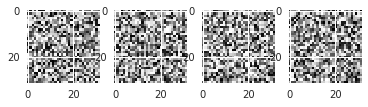

(Iter 0). Current train: 0.062500, Current val: 0.125000.


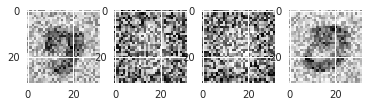

(Iter 50). Current train: 0.140625, Current val: 0.093750.


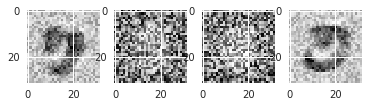

(Iter 100). Current train: 0.125000, Current val: 0.132812.


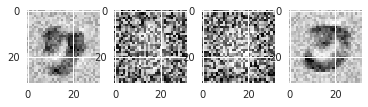

(Iter 150). Current train: 0.093750, Current val: 0.093750.


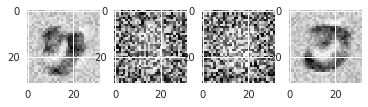

(Iter 200). Current train: 0.125000, Current val: 0.140625.


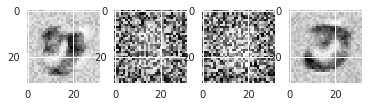

(Iter 250). Current train: 0.109375, Current val: 0.125000.


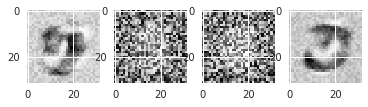

(Iter 300). Current train: 0.250000, Current val: 0.156250.


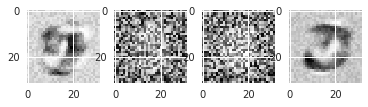

(Iter 350). Current train: 0.234375, Current val: 0.203125.


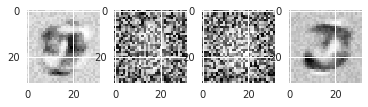

(Iter 400). Current train: 0.218750, Current val: 0.179688.


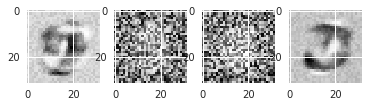

(Iter 450). Current train: 0.203125, Current val: 0.195312.


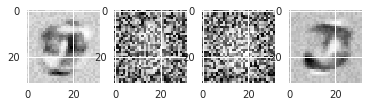

(Iter 500). Current train: 0.187500, Current val: 0.210938.


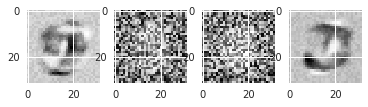

(Iter 550). Current train: 0.171875, Current val: 0.226562.


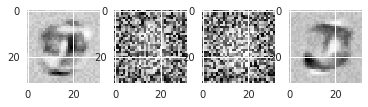

(Iter 600). Current train: 0.234375, Current val: 0.265625.


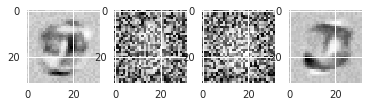

(Iter 650). Current train: 0.281250, Current val: 0.195312.


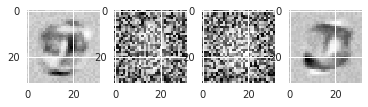

(Iter 700). Current train: 0.281250, Current val: 0.210938.


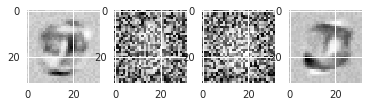

(Iter 750). Current train: 0.140625, Current val: 0.265625.


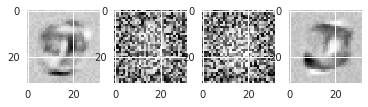

(Iter 800). Current train: 0.234375, Current val: 0.242188.


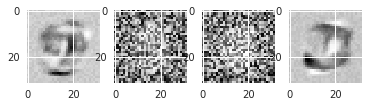

(Iter 850). Current train: 0.140625, Current val: 0.296875.


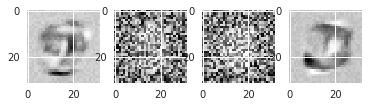

(Iter 900). Current train: 0.312500, Current val: 0.234375.


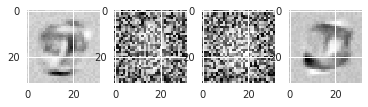

(Iter 950). Current train: 0.390625, Current val: 0.250000.


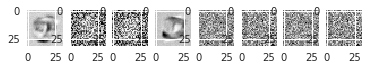

(Iter 1000). Current train: 0.296875, Current val: 0.281250.


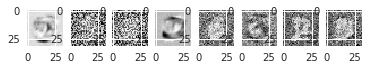

(Iter 1050). Current train: 0.390625, Current val: 0.468750.


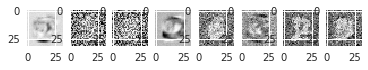

(Iter 1100). Current train: 0.546875, Current val: 0.625000.


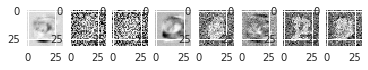

(Iter 1150). Current train: 0.578125, Current val: 0.562500.


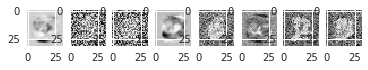

(Iter 1200). Current train: 0.484375, Current val: 0.578125.


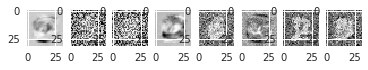

(Iter 1250). Current train: 0.515625, Current val: 0.546875.


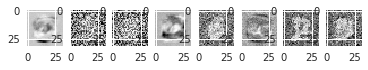

(Iter 1300). Current train: 0.562500, Current val: 0.640625.


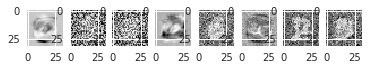

(Iter 1350). Current train: 0.609375, Current val: 0.601562.


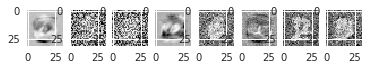

(Iter 1400). Current train: 0.718750, Current val: 0.546875.


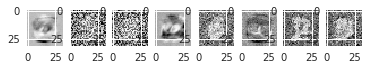

(Iter 1450). Current train: 0.703125, Current val: 0.671875.


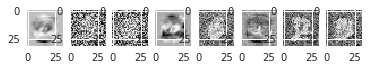

(Iter 1500). Current train: 0.625000, Current val: 0.609375.


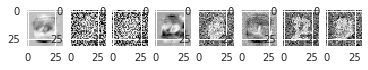

(Iter 1550). Current train: 0.656250, Current val: 0.687500.


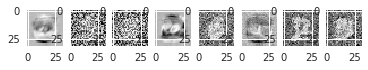

(Iter 1600). Current train: 0.703125, Current val: 0.609375.


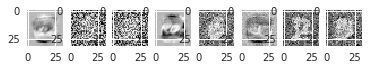

(Iter 1650). Current train: 0.687500, Current val: 0.640625.


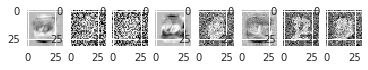

(Iter 1700). Current train: 0.671875, Current val: 0.625000.


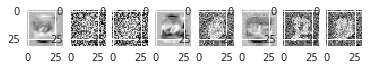

(Iter 1750). Current train: 0.562500, Current val: 0.585938.


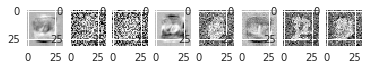

(Iter 1800). Current train: 0.625000, Current val: 0.609375.


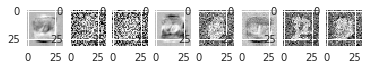

(Iter 1850). Current train: 0.671875, Current val: 0.625000.


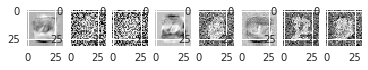

(Iter 1900). Current train: 0.687500, Current val: 0.585938.


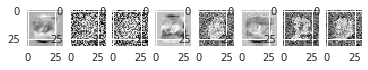

(Iter 1950). Current train: 0.734375, Current val: 0.679688.


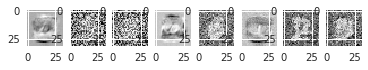

(Iter 2000). Current train: 0.625000, Current val: 0.679688.


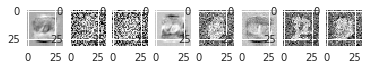

(Iter 2050). Current train: 0.703125, Current val: 0.726562.


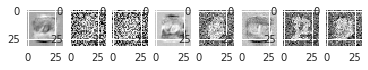

(Iter 2100). Current train: 0.656250, Current val: 0.570312.


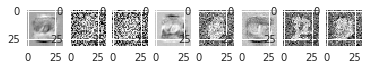

(Iter 2150). Current train: 0.640625, Current val: 0.687500.


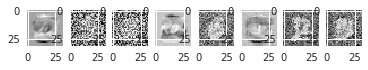

(Iter 2200). Current train: 0.703125, Current val: 0.625000.


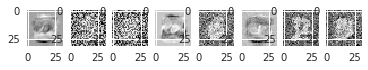

(Iter 2250). Current train: 0.625000, Current val: 0.679688.


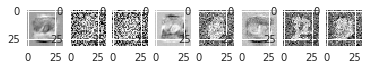

(Iter 2300). Current train: 0.625000, Current val: 0.648438.


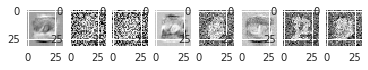

(Iter 2350). Current train: 0.625000, Current val: 0.695312.


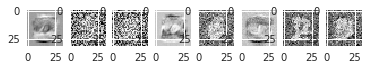

(Iter 2400). Current train: 0.781250, Current val: 0.765625.


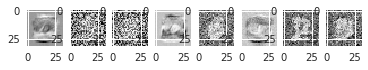

(Iter 2450). Current train: 0.640625, Current val: 0.781250.


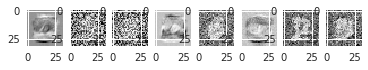

(Iter 2500). Current train: 0.687500, Current val: 0.703125.


In [135]:
# Go, go, go!
model = FC_Net(4)
if use_gpu:
    model = model.cuda()
dataset = DatasetCudaWrapper(MnistDataset(64)) if use_gpu else MnistDataset(64)

visualize_weights(model, dataset)

# FIN
## But what about Cifar-10? And ImageNet?

Training on even Cifar-10 and ImageNet tends to take quite a long time, and isn't very appropriate for a jupyter notebook. We instead leave this to our library code and "batch tests".

I hope you enjoyed reading through this :)
And I hope that this might be useful to you at some point :) 

And I love you Ioana <3